# Libraries

import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
!pip install openpyxl
#from google.colab import drive
#drive.mount('/content/drive')

# Preprocessing

## Read Data

file_path = "/content/RainbowTrout_Growth_Data.xlsx"
env_data = pd.read_excel(file_path, sheet_name=1)
fish_data = pd.read_excel(file_path, sheet_name=2)

## Create Date/Time Variables

fish_data['ReleaseDate'] = pd.to_datetime(fish_data['Release Trip'])
fish_data['RecoveryDate'] = pd.to_datetime(fish_data['Recovery Trip'])
# Extract month and year
fish_data['ReleaseMonth'] = fish_data['ReleaseDate'].dt.month
fish_data['ReleaseYear'] = fish_data['ReleaseDate'].dt.year
fish_data['RecoveryMonth'] = fish_data['RecoveryDate'].dt.month
fish_data['RecoveryYear'] = fish_data['RecoveryDate'].dt.year
#NOTE:  Time at Large and Days Between were identical!

## Drop Unneeded Variables

fish_data = fish_data.drop(columns=['Recovery River Mile',
                                    'Weight at Recapture', 'Length_Growth',
                                    'ReleaseDate','RecoveryDate', 'Weight_Growth',
                                    ])
fish_data = fish_data.rename(columns={
    'Forklength at Release': 'L1',
    'Forklength at Recapture': 'L2'
})
fish_data.head()

## Convert to Dummies

# Get modal values before dummy creation

recovery_month_mode = fish_data['RecoveryMonth'].mode()[0]
recovery_year_mode = fish_data['RecoveryYear'].mode()[0]

# Create dummies
fish_data = pd.get_dummies(fish_data,
                           columns=[ 'ReleaseMonth','ReleaseYear','RecoveryMonth', 'RecoveryYear'],
                           drop_first=False)

# Drop dummy columns corresponding to modes
fish_data.drop([
    f'RecoveryMonth_{recovery_month_mode}',
    f'RecoveryYear_{recovery_year_mode}'
], axis=1, inplace=True)

# Convert all dummy columns to integers (0/1)
dummy_cols = [col for col in fish_data.columns if
              col.startswith('RecoveryMonth_') or
              col.startswith('RecoveryYear_') or
              col.startswith('ReleaseMonth_') or
              col.startswith('ReleaseYear_')]

fish_data[dummy_cols] = fish_data[dummy_cols].astype(int)

fish_data.head()

## Merge with Environmental Variables
(MODIFIED, Weighted Average Approach)

# Function to merge environmental variables with fish data using weighted averages
def merge_environmental_data(fish_data, env_data, env_vars):
    """
    Merges environmental data with fish growth data using a weighted average approach.

    Parameters:
    - fish_data: DataFrame containing fish release and recovery dates
    - env_data: DataFrame containing environmental measurements over time intervals
    - env_vars: List of environmental variable names to merge

    Returns:
    - fish_data with added environmental variables
    """
    # First, ensure dates are in datetime format
    fish_data['Release Trip'] = pd.to_datetime(fish_data['Release Trip'])
    fish_data['Recovery Trip'] = pd.to_datetime(fish_data['Recovery Trip'])

    # Process env_data dates
    def parse_env_dates(interval):
        start_part, end_part = interval.split('-')
        start_date = pd.to_datetime(start_part + '-01', format='%b%y-%d')
        end_date = pd.to_datetime(end_part + '-01', format='%b%y-%d') + pd.DateOffset(months=1, days=-1)
        return start_date, end_date

    # Create start and end date columns
    env_data[['start_date', 'end_date']] = env_data['Trip Interval'].apply(lambda x: pd.Series(parse_env_dates(x)))

    # Initialize environmental variable columns in fish_data
    for var in env_vars:
        fish_data[var] = np.nan

    # Define the weighted average function
    def get_weighted_env_values(release_date, recovery_date):
        """
        Calculate weighted environmental values for a fish's time at large.

        Parameters:
        - release_date: Date the fish was released
        - recovery_date: Date the fish was recaptured

        Returns:
        - Dictionary with weighted average values for each environmental variable
        """
        # Find overlapping intervals
        overlaps = env_data[(env_data['end_date'] >= release_date) & (env_data['start_date'] <= recovery_date)]

        if len(overlaps) == 0:
            return {var: np.nan for var in env_vars}

        # Calculate total days fish was at large
        total_days = (recovery_date - release_date).days + 1
        if total_days <= 0:
            return {var: np.nan for var in env_vars}

        # Calculate weighted values for each variable
        weighted_values = {var: 0.0 for var in env_vars}

        for _, env_row in overlaps.iterrows():
            # Calculate overlap period
            overlap_start = max(release_date, env_row['start_date'])
            overlap_end = min(recovery_date, env_row['end_date'])
            overlap_days = (overlap_end - overlap_start).days + 1

            # Calculate weight
            weight = overlap_days / total_days

            # Add weighted values
            for var in env_vars:
                if pd.notna(env_row[var]):
                    weighted_values[var] += weight * env_row[var]

        return weighted_values

    # Apply the function to each row in fish_data
    print("Merging environmental data (this may take a moment)...")
    for idx, row in fish_data.iterrows():
        weighted_values = get_weighted_env_values(row['Release Trip'], row['Recovery Trip'])
        for var in env_vars:
            fish_data.loc[idx, var] = weighted_values[var]

    # Report success statistics
    match_counts = fish_data[env_vars].notna().sum()
    print(f"Environmental data merge complete.")
    print(f"Records with environmental data:\n{match_counts}")
    print(f"Success rate: {match_counts.mean() / len(fish_data) * 100:.1f}%")

    return fish_data

# Define environmental variables to merge
env_vars = ["Discharge", "Water Temperature", "Solar Insolation",
           "Soluble Reactive Phosphorous Concentration", "Rainbow Trout Biomass"]

# Apply the function to merge data
fish_data_with_env = merge_environmental_data(fish_data, env_data, env_vars)

## Look at Data

fish_data.head()

## Drop Variables Used Solely for Merge

fish_data = fish_data.drop(columns=['Release Trip', 'Recovery Trip'])

## Verify Structure

# Convert all object columns to numeric
for col in fish_data.select_dtypes(include='object').columns:
    fish_data[col] = pd.to_numeric(fish_data[col], errors='coerce')


## Identify Extreme Outliers


#Clean Copy of DF
fish_model_data = fish_data.copy()

# Calculate Q1, Q3, and IQR
Q1 = fish_model_data['L2'].quantile(0.25)
Q3 = fish_model_data['L2'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds (using 3x IQR)
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Identify outliers
outliers = fish_model_data[(fish_model_data['L2'] < lower_bound) |
                           (fish_model_data['L2'] > upper_bound)]

# Display outliers
print(f"Outliers detected: {len(outliers)}")
print(outliers[['L2']])

## Describe

fish_data.describe()

## Boxplot of Dependent Variable

sns.boxplot(x=fish_model_data['L2'], color='lightblue')
plt.xlabel('Forklength at Recapture')
plt.title('Forklength at Recapture')
plt.show()

## Correlation Analysis

from scipy.stats import pearsonr
from matplotlib.patches import Ellipse

# Subset of only continuous (non-dummy) variables
cont_vars = [
    'Time at Large', 'L1', 'L2',
    'Discharge', 'Water Temperature', 'Solar Insolation',
    'Soluble Reactive Phosphorous Concentration', 'Weight at Release',
    'Release River Mile'
]

df = fish_data[cont_vars].dropna()

# Custom PairGrid
g = sns.PairGrid(df, diag_sharey=False)

# Lower: correlation coefficients
def corr_func(x, y, **kwargs):
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha='center', va='center', fontsize=10)

# Upper: scatterplots (could sub with kde or box-like ellipses)
def scatter_func(x, y, **kwargs):
    ax = plt.gca()
    sns.scatterplot(x=x, y=y, alpha=0.4, s=20, ax=ax)

# Diagonal: histograms
g.map_lower(corr_func)
g.map_diag(sns.histplot, kde=True)
g.map_upper(scatter_func)

# Adjust layout
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Correlations and Distributions Among Key Growth Variables')
plt.show()


## Create Clean Dataset and Save

# Export the processed data
fish_model_data = fish_data.copy()
fish_model_data.to_csv('fish_model_data.csv', index=False)
print("Data exported successfully to 'fish_model_data.csv'")

# *Start Here:  Metrics Function*

In [1]:
def get_model_metrics(y_true, y_pred, model_name="Model", k_params=None, model=None):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import numpy as np
    import pandas as pd
    import torch

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)

    # Estimate k_params if not provided and model is given
    if k_params is None and model is not None:
        try:
            # PyTorch model
            k_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Inferred k_params = {k_params}")
        except Exception as e:
            print(f"Could not infer k_params: {e}")
            k_params = None

    # Core metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Model: {model_name}")
    print(f"n = {n}, k_params = {k_params}")

    adj_r2 = np.nan
    aic = np.nan
    aicc = np.nan
    bic = np.nan

    if k_params is not None and k_params < n:
        residuals = y_true - y_pred
        rss = np.sum(residuals ** 2)
        sigma2 = rss / n

        print(f"RSS = {rss}")
        print(f"sigma² = {sigma2}")

        if sigma2 > 0:
            log_likelihood = -0.5 * n * (np.log(2 * np.pi) + np.log(sigma2) + 1)
            print(f"log_likelihood = {log_likelihood}")

            aic = -2 * log_likelihood + 2 * k_params
            print(f"AIC = {aic}")

            if (n - k_params - 1) > 0:
                aicc = aic + (2 * k_params * (k_params + 1)) / (n - k_params - 1)
                adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - k_params - 1))
                print(f"AICC = {aicc}, Adj R² = {adj_r2}")
            else:
                print("Skipping AICC and Adj R²: n - k_params - 1 is too small")

            bic = -2 * log_likelihood + np.log(n) * k_params
            print(f"BIC = {bic}")
        else:
            print("sigma² is non-positive. Skipping AIC/BIC.")
    else:
        print("Invalid k_params. Skipping AIC/AICC/BIC.")

    return pd.DataFrame([{
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "Adj R²": adj_r2,
        "AIC": aic,
        "AICC": aicc,
        "BIC": bic
    }])


# Libraries to Bypass Initial Preprocessing

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Train / Test Split

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load data
fish_model_data = pd.read_csv("fish_model_data.csv")

# Define predictors and target
X = fish_model_data.drop(columns=["L2"])
y = fish_model_data["L2"]
feature_names = X.columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Record test set indices
valid_indices = X_test.index
test_indices = X_test.index

# Ensure correct y_test
y_test = fish_model_data.loc[valid_indices, "L2"]
y_true = y_test

# Identify dichotomous and continuous columns
dichotomous_cols = X_train.columns[X_train.nunique() == 2]
continuous_cols = X_train.columns.difference(dichotomous_cols)

# ---- VERSION 1: Fully Scaled ----
scaler_full = MinMaxScaler()
X_train_scaled= X_train.copy()
X_test_scaled= X_test.copy()
X_train_scaled[continuous_cols] = scaler_full.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler_full.transform(X_test[continuous_cols])

# ---- VERSION 2: All But L1 and Time at Large Scaled ----
exclude_from_scaling = ["Time at Large", "L1"]
cols_to_scale_partial = continuous_cols.difference(exclude_from_scaling)

scaler_partial = MinMaxScaler()
X_train_scaled_partial = X_train.copy()
X_test_scaled_partial = X_test.copy()
X_train_scaled_partial[cols_to_scale_partial] = scaler_partial.fit_transform(X_train[cols_to_scale_partial])
X_test_scaled_partial[cols_to_scale_partial] = scaler_partial.transform(X_test[cols_to_scale_partial])

# Output sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

highlight_df = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'R²', 'Adj R²', 'AIC', 'AICC', 'BIC'])


Training set size: 6858
Testing set size: 2940


# Deterministic Biological Calculation

                  Model       RMSE        MAE        R²    Adj R²  \
0      VBGM (benchmark)  86.289396  77.193476 -0.000332 -0.001014   
1  Gompertz (benchmark)  86.368355  65.225730 -0.002164 -0.002846   

            AIC          AICC           BIC  
0  34558.674074  34558.678159  34570.646403  
1  34564.052088  34564.056174  34576.024418  


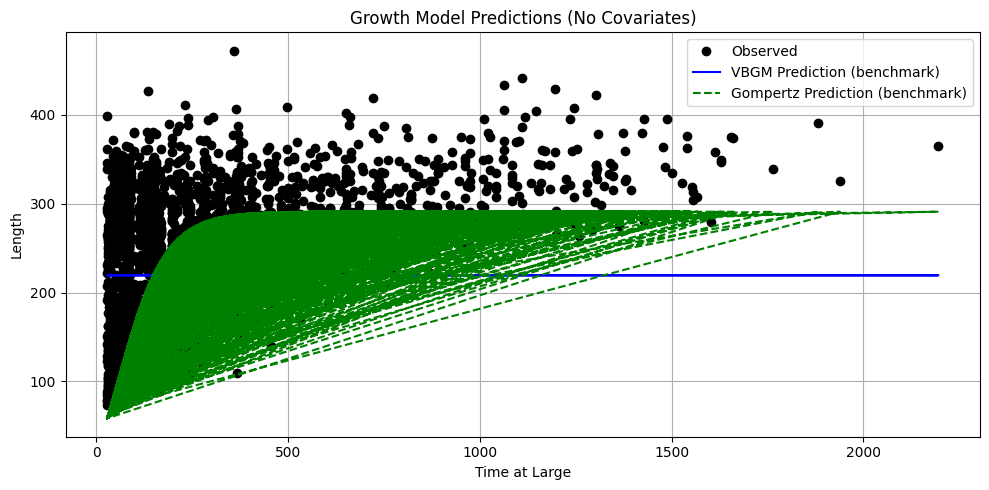

In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Extract training and test features
t_train = X_train['Time at Large'].to_numpy()
L1_train = X_train['L1'].to_numpy()
y_train_vals = y_train.to_numpy().ravel()

t_test = X_test['Time at Large'].to_numpy()
L1_test = X_test['L1'].to_numpy()
y_test_vals = y_test.to_numpy().ravel()

# Growth models (benchmark: no covariates)
def vbgm(t, L_inf, k):
    return L_inf - (L_inf - L1_train) * np.exp(-k * t)

def gompertz(t, A, B):
    return A * np.exp(-np.exp(-B * t + np.log(A / L1_train)))

# Fit models
popt_vbgm, _ = curve_fit(vbgm, t_train, y_train_vals, bounds=(0, np.inf))
popt_gomp, _ = curve_fit(gompertz, t_train, y_train_vals, bounds=(0, np.inf))

# Prediction functions (no covariates)
def vbgm_pred_func(t, L1, L_inf, k):
    return L_inf - (L_inf - L1) * np.exp(-k * t)

def gompertz_pred_func(t, L1, A, B):
    return A * np.exp(-np.exp(-B * t + np.log(A / L1)))

# Predictions
vbgm_preds = vbgm_pred_func(t_test, L1_train[0], *popt_vbgm)  # Use first training L1
gompertz_preds = gompertz_pred_func(t_test, L1_train[0], *popt_gomp)  # Use first training L1
# Metric calculation
def get_model_metrics(y_true, y_pred, model_name="Model", k_params=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)
    if k_params is None:
        k_params = 3  # default fallback

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    sigma2 = rss / n

    aic = aicc = bic = adj_r2 = np.nan
    if sigma2 > 0:
        log_likelihood = -0.5 * n * (np.log(2 * np.pi) + np.log(sigma2) + 1)
        aic = -2 * log_likelihood + 2 * k_params
        if (n - k_params - 1) > 0:
            aicc = aic + (2 * k_params * (k_params + 1)) / (n - k_params - 1)
            adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - k_params - 1))
        bic = -2 * log_likelihood + np.log(n) * k_params

    return pd.DataFrame([{
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "Adj R²": adj_r2,
        "AIC": aic,
        "AICC": aicc,
        "BIC": bic
    }])

# Get metrics (no covariates: 2 parameters per model)
vb_metrics = get_model_metrics(y_test_vals, vbgm_preds, "VBGM (benchmark)", k_params=2)
go_metrics = get_model_metrics(y_test_vals, gompertz_preds, "Gompertz (benchmark)", k_params=2)
metrics_df = pd.concat([vb_metrics, go_metrics], ignore_index=True)

print(metrics_df)

# Optional plot
plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test_vals, 'ko', label='Observed')
plt.plot(t_test, vbgm_preds, 'b-', label='VBGM Prediction (benchmark)')
plt.plot(t_test, gompertz_preds, 'g--', label='Gompertz Prediction (benchmark)')
plt.xlabel('Time at Large')
plt.ylabel('Length')
plt.title('Growth Model Predictions (No Covariates)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Metrics

In [5]:
highlight_df = pd.DataFrame(columns=[
    "Model", "RMSE", "MAE", "R²", "Adj R²", "AIC", "AICC", "BIC"
])
# Apply the metrics function to VBGM
vbgm_results = get_model_metrics(
    y_true=y_test,
    y_pred=vbgm_preds,
    model_name="VBGM",
    k_params=3  # L∞, K, and t₀
)

highlight_df = pd.concat([
    highlight_df,
    get_model_metrics(y_true, vbgm_preds, k_params=X_test.shape[1], model_name="Baseline VBGM")
], ignore_index=True)

# Apply the metrics function to Gompertz
gompertz_results = get_model_metrics(
    y_true=y_test,
    y_pred=gompertz_preds,
    model_name="Gompertz",
    k_params=3  # A, B, and C
)
highlight_df = pd.concat([
    highlight_df,
    get_model_metrics(y_true, gompertz_preds, k_params=X_test.shape[1], model_name="Baseline Gompertz")
], ignore_index=True)

highlight_df


,Model,RMSE,MAE,R²,Adj R²,AIC,AICC,BIC
0,Baseline VBGM,86.289396,77.193476,-0.000332,-0.016589,34648.674074,34650.234239,34930.023822
1,Baseline Gompertz,86.368355,65.225730,-0.002164,-0.018451,34654.052088,34655.612254,34935.401837


# GPU Option

In [6]:

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# Descriptive Statistics


In [7]:
# Define prefixes to exclude
prefixes_to_exclude = ['ReleaseYear', 'ReleaseMonth', 'RecoveryYear', 'RecoveryMonth']

# Filter numeric columns
numeric_cols = fish_model_data.select_dtypes(include='number').columns

# Keep only those columns that don't start with any of the prefixes
filtered_cols = [col for col in numeric_cols if not any(col.startswith(prefix) for prefix in prefixes_to_exclude)]

# Compute summary statistics on the filtered numeric columns
summary = fish_model_data[filtered_cols].agg(['mean', 'std', 'min', 'median', 'max', 'skew', 'kurtosis']).T
summary = summary.round(3)

summary


,mean,std,min,median,max,skew,kurtosis
Release River Mile,-3.740,0.688,-14.890,-3.750,-1.960,-1.119,13.874
Time at Large,243.473,285.592,28.000,130.500,2256.000,2.431,6.919
L1,187.260,87.533,70.000,163.000,457.000,0.363,-1.241
L2,218.920,85.793,74.000,230.000,472.000,0.057,-1.301
Weight at Release,118.776,132.940,3.500,51.000,1182.000,1.388,1.980
Discharge,18.648,4.136,11.333,17.811,32.113,1.341,1.743
Water Temperature,16.855,3.890,8.654,16.047,27.141,0.605,0.005
Solar Insolation,50.239,17.864,19.177,49.711,105.920,0.501,0.091
Soluble Reactive Phosphorous Concentration,0.007,0.003,0.002,0.007,0.017,0.424,-0.273
Rainbow Trout Biomass,12.384,6.092,5.558,10.450,34.029,0.989,0.199


# Bayesian OLS Model

## 📈 Bayesian Linear Regression Model

We estimate the posterior distribution of the regression coefficients $\boldsymbol{\beta}$ and observation noise $\sigma$ using Bayesian inference:

- $\mathbf{X}$: Design matrix (with intercept)  
- $\mathbf{y}$: Observed response  
- $\boldsymbol{\beta}$: Coefficients for each predictor  
- $\sigma$: Standard deviation of residuals

---

### 📌 Full Posterior

$$
\begin{aligned}
p(&\boldsymbol{\beta}, \sigma \mid \mathbf{X}, \mathbf{y}) = \\
&\frac{
    \underbrace{p(\mathbf{y} \mid \mathbf{X}, \boldsymbol{\beta}, \sigma)}_{\text{Likelihood}} \cdot
    \underbrace{p(\boldsymbol{\beta})}_{\text{Normal prior}} \cdot
    \underbrace{p(\log \sigma)}_{\text{LogNormal prior}}
}{
    \int \int p(\mathbf{y} \mid \mathbf{X}, \boldsymbol{\beta}, \sigma) \cdot p(\boldsymbol{\beta}) \cdot p(\log \sigma)\ d\boldsymbol{\beta}\ d\sigma
}
\end{aligned}
$$

---

### 🔢 Likelihood

$$
\mathbf{y} \sim \mathcal{N}(\mathbf{X} \boldsymbol{\beta},\ \sigma^2)
$$

---

### 🎲 Priors

- $\beta_j \sim \mathcal{N}(0,\ 5^2)$ for all $j$ (including intercept)  
- $\log \sigma \sim \mathcal{N}(0,\ 1^2)$  
- $\sigma = \exp(\log \sigma)$ (ensures positivity and improves sampling)

---

### 🧠 Notes

- Priors are weakly informative and symmetric around 0, allowing both positive and negative slopes.
- The log-normal prior on $\sigma$ stabilizes sampling while avoiding degenerate variance.
- The model is implemented in PyMC with vectorized operations for efficiency.


## Bayesian Estimation

In [8]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# === LOAD DATA ===
data = pd.read_csv("fish_model_data.csv")

# Target and predictors
y = data["L2"]
X = data.drop(columns=["L2"])

# Add intercept column
X_train_np = np.column_stack((np.ones(len(X_train_scaled)), X_train_scaled.astype(float).values))
X_test_np = np.column_stack((np.ones(len(X_test_scaled)), X_test_scaled.astype(float).values))

# Convert to JAX arrays
X_train_jax = jnp.array(X_train_np)
X_test_jax = jnp.array(X_test_np)
y_train_jax = jnp.array(y_train.values)

# === MODEL DEFINITION ===
def bayesian_linear_model(X, y=None):
    n_features = X.shape[1]

    beta = numpyro.sample("beta", dist.Normal(0, 5).expand([n_features]))
    sigma = numpyro.sample("sigma", dist.LogNormal(0, 1))
    mu = jnp.dot(X, beta)

    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

# === MCMC SAMPLING ===
def run_mcmc(X, y):
    kernel = NUTS(
        bayesian_linear_model,
        init_strategy=init_to_median(),
        max_tree_depth=10,
        target_accept_prob=0.8
    )
    mcmc = MCMC(
        kernel,
        num_warmup=500,
        num_samples=1000,
        num_chains=4,
        progress_bar=True
    )
    mcmc.run(jax.random.PRNGKey(42), X=X, y=y)
    return mcmc

# Run full MCMC with all data
mcmc = run_mcmc(X_train_jax, y_train_jax)
mcmc.print_summary()

# Extract posterior samples
samples = mcmc.get_samples()
beta_samples = samples['beta']
sigma_samples = samples['sigma']

# === PREDICTIONS ===
def make_predictions(beta_samples, sigma_samples, X_test):
    n_samples = len(beta_samples)
    pred_samples = []
    for i in range(n_samples):
        mu = jnp.dot(X_test, beta_samples[i])
        noise = jax.random.normal(jax.random.PRNGKey(i), mu.shape) * sigma_samples[i]
        pred_samples.append(mu + noise)

    pred_samples = jnp.stack(pred_samples)
    return {
        'mean': pred_samples.mean(axis=0),
        'std': pred_samples.std(axis=0),
        'lower_95': jnp.percentile(pred_samples, 2.5, axis=0),
        'upper_95': jnp.percentile(pred_samples, 97.5, axis=0)
    }

predictions = make_predictions(beta_samples, sigma_samples, X_test_jax)

print("\nPrediction Summary:")
print(f"Mean prediction range: [{predictions['mean'].min():.3f}, {predictions['mean'].max():.3f}]")
print(f"Average prediction std: {predictions['std'].mean():.3f}")


sample: 100%|██████████████████████████| 1500/1500 [00:06<00:00, 221.89it/s, 127 steps of size 5.48e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     65.07      3.45     65.05     59.61     70.86   2740.67      1.00
   beta[1]     22.99      3.39     22.96     17.59     28.76   3467.58      1.00
   beta[2]    178.51      2.99    178.47    173.80    183.53   2333.49      1.00
   beta[3]    235.99      2.48    236.01    231.77    239.77   2805.69      1.00
   beta[4]     76.65      3.66     76.63     70.73     82.38   3028.58      1.00
   beta[5]      8.27      1.81      8.27      5.38     11.34   1121.07      1.00
   beta[6]      5.58      2.51      5.57      1.65      9.91   2256.90      1.00
   beta[7]     10.38      2.54     10.37      6.24     14.64   2274.32      1.00
   beta[8]      7.81      1.84      7.82      4.73     10.73   1234.53      1.00
   beta[9]     -0.66      1.84     -0.67     -3.67      2.36   1230.93      1.00
  beta[10]     19.67      2.94     19.65     14.89     24.61   2709.94      1.00
  beta[11]      0.81      1

## Results

In [10]:
import arviz as az

idata_blr = az.from_numpyro(mcmc)
print("Num divergences:", idata_blr.sample_stats["diverging"].sum().item())
# Step 1: Real feature names (including intercept)
feature_names = ['intercept'] + X_train_scaled.columns.tolist()

# Step 2: Get summary
df_summary = az.summary(idata_blr, var_names=["beta", "sigma"], round_to=2)

# Step 3: Set named row index
param_names = [f"beta[{name}]" for name in feature_names] + ["sigma"]
df_summary.index = param_names

# Step 4: Display or export
print(df_summary.to_string())

# Export
df_summary.to_csv("regression_summary.csv")
# print(df_summary.to_latex())


Num divergences: 0
                                                    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
beta[intercept]                                    65.07  3.45   58.93    71.73       0.07     0.05   2772.36   3110.91    1.0
beta[Release River Mile]                           22.99  3.39   17.15    29.88       0.06     0.05   3498.24   2716.81    1.0
beta[Time at Large]                               178.51  2.99  173.10   184.20       0.06     0.04   2343.79   2856.16    1.0
beta[L1]                                          235.99  2.48  231.47   240.68       0.05     0.04   2864.86   3033.65    1.0
beta[Weight at Release]                            76.65  3.66   70.12    83.60       0.07     0.06   3075.44   2588.19    1.0
beta[ReleaseMonth_1]                                8.27  1.81    4.87    11.70       0.05     0.03   1128.54   1725.55    1.0
beta[ReleaseMonth_2]                                5.58  2.51    0.90    10.37       0.05  

## Visualizations

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

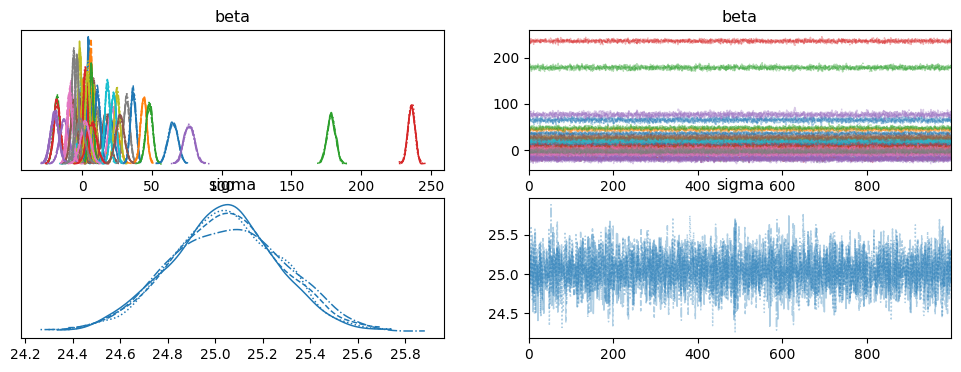

In [11]:
az.plot_trace(idata_blr)


array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>,
        <Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>],
       [<Axes: title={'center': 'beta\n8'}>,
        <Axes: title={'center': 'beta\n9'}>,
        <Axes: title={'center': 'beta\n10'}>,
        <Axes: title={'center': 'beta\n11'}>],
       [<Axes: title={'center': 'beta\n12'}>,
        <Axes: title={'center': 'beta\n13'}>,
        <Axes: title={'center': 'beta\n14'}>,
        <Axes: title={'center': 'beta\n15'}>],
       [<Axes: title={'center': 'beta\n16'}>,
        <Axes: title={'center': 'beta\n17'}>,
        <Axes: title={'center': 'beta\n18'}>,
        <Axes: title={'center': 'beta\n19'}>],
       [<Axes: title={'center': 'beta\n20'}>,
        <Axes: title={'center': 'beta\n

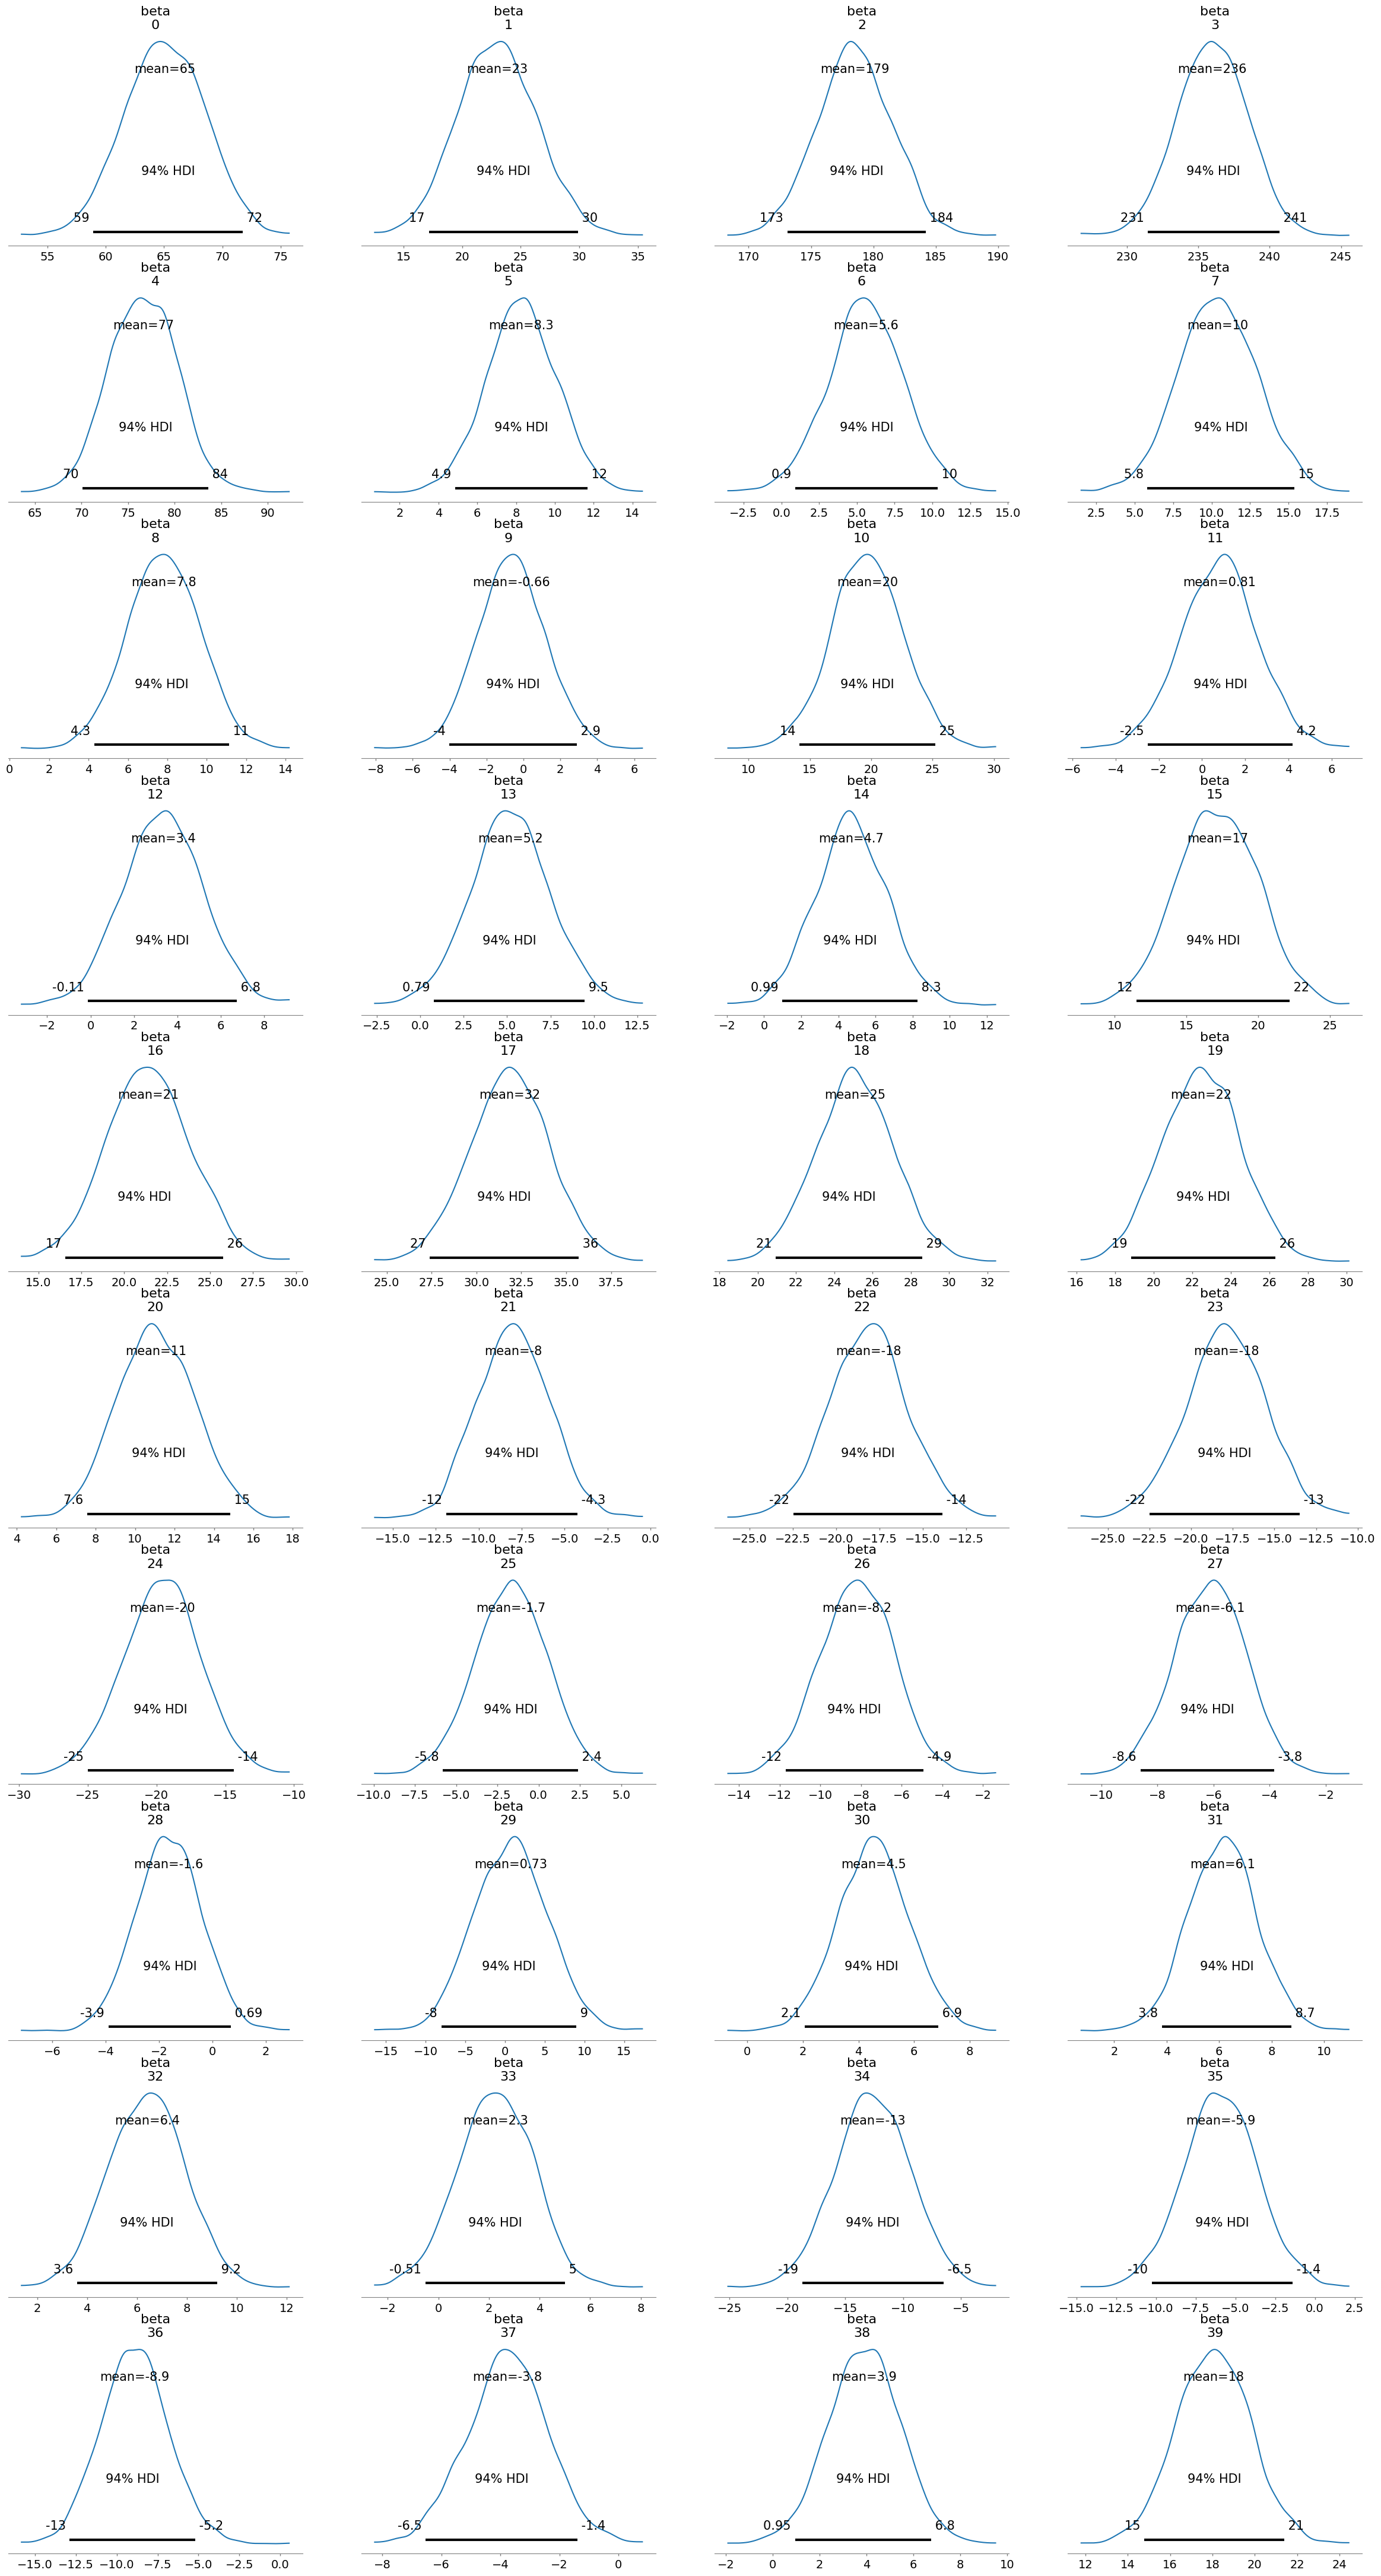

In [12]:
az.plot_posterior(idata_blr)

## Predictions-GPU

In [13]:
from numpyro.infer import Predictive
def linear_regression(X, y=None):
    beta = numpyro.sample("beta", dist.Normal(0, 5).expand([X.shape[1]]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))
    mu = jnp.dot(X, beta)

    numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

predictive = Predictive(linear_regression, posterior_samples=mcmc.get_samples())
preds_test = predictive(jax.random.PRNGKey(123), X=X_test_np)
L2_pred_ols = np.mean(preds_test["obs"], axis=0)  # shape: (n_test_samples,)


## Gelman–Rubin Diagnostic ($\hat{R}$)

The **Gelman–Rubin statistic**, also known as **$\hat{R}$**, is a diagnostic used to assess the convergence of Markov Chain Monte Carlo (MCMC) simulations. It compares the variance **between chains** to the variance **within chains**. If the chains have converged to the same target posterior distribution, these variances should be nearly equal.

### Formula:

$$
\hat{R} = \sqrt{ \frac{\hat{V}}{W} }
$$

Where:
- $W$ is the **within-chain variance** (average of variances across each chain),
- $\hat{V}$ is the **posterior variance estimate**, which includes both within- and between-chain variation.

More specifically:

$$
\hat{V} = \frac{n - 1}{n} W + \frac{1}{n} B
$$

with:
- $B$ = between-chain variance,
- $n$ = number of samples per chain.

### Interpretation Guidelines:

| $\hat{R}$ Value | Interpretation                                  |
|------------------|-------------------------------------------------|
| $\leq 1.01$       | Converged (ideal)                               |
| $1.01 - 1.05$     | Probably converged, but inspect more closely    |
| $> 1.05$          | Not converged — potential bias or multimodality |
| $> 1.10$          | Definitely not converged — results not reliable |

> A value of $\hat{R} \approx 1.00$ suggests that the chains have mixed well and the posterior is likely sampled adequately.


## Effective Sample Size (ESS)

The **Effective Sample Size (ESS)** measures the number of effectively independent samples drawn from a Markov Chain Monte Carlo (MCMC) simulation. Because MCMC samples are typically autocorrelated, the true amount of independent information is lower than the total number of draws.

ESS estimates how many *independent* samples the chain represents, taking autocorrelation into account.

### Formula:

Let $\rho_k$ denote the lag-$k$ autocorrelation of the chain. Then:

$$
\text{ESS} = \frac{N}{1 + 2 \sum_{k=1}^{\infty} \rho_k}
$$

Where:
- $N$ is the total number of samples,
- $\rho_k$ is the autocorrelation at lag $k$.

In practice, the summation is truncated when $\rho_k$ becomes negligibly small or negative.

### Why ESS Matters:

Even if you draw thousands of samples, high autocorrelation reduces how many of them are effectively unique. A small ESS suggests high redundancy in the samples and less reliable estimates.

### Types in ArviZ:

- **`ess_bulk`**: Measures ESS for the main mass ("bulk") of the posterior.
- **`ess_tail`**: Focuses on the tails of the posterior, which affect credible intervals.

### Interpretation Guidelines:

| ESS Value       | Interpretation                            |
|-----------------|--------------------------------------------|
| $\geq 400$      | Reliable estimate (ideal)                  |
| $100 - 400$     | Acceptable, but consider longer chains     |
| $< 100$         | Low — Posterior estimates are unreliable   |

> High ESS values indicate efficient sampling and reliable posterior summaries. Low ESS may require more samples, better tuning, or model reparameterization.


## Metrics

In [14]:
# Initialize with proper columns

# Add first model
highlight_df = pd.concat([
    highlight_df,
    get_model_metrics(y_true, L2_pred_ols, k_params=X_test_np.shape[1], model_name="Bayesian Linear Model")
], ignore_index=True)

# Copy to bayesian_df if needed
bayesian_df = highlight_df.copy()

# Show results
display(highlight_df)


,Model,RMSE,MAE,R²,Adj R²,AIC,AICC,BIC
0,Baseline VBGM,86.289396,77.193476,-0.000332,-0.016589,34648.674074,34650.234239,34930.023822
1,Baseline Gompertz,86.368355,65.225730,-0.002164,-0.018451,34654.052088,34655.612254,34935.401837
2,Bayesian Linear Model,25.723943,18.547136,0.911099,0.909623,27534.200927,27535.828046,27821.536840


# ML Model Libraries

In [16]:
# Machine Learning and Model Training

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

# Advanced Machine Learning Frameworks
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
import random

# SVR
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# Optimization
from scipy.optimize import minimize

# Regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score



# Tree & SVR Models


## Tree & SVR Estimation

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import time
import xgboost as xgb
import lightgbm as lgb

# === MAIN OPTIMIZED CODE ===
# Define models with best parameters
# Best RF Parameters:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 
# 'max_depth': 25}
# Best XGBoost Parameters:
# {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 4, 'eta': 0.05, 
#'colsample_bytree': 1.0}
# Best Parameters LightGBM: {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0.1, 'num_leaves': 31, 
#'n_estimators': 150, 'max_depth': 20,'learning_rate': 0.05, 'colsample_bytree': 0.9}
# Best Linear SVR Parameters: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 0.5, 'C': 100}
# Best rbf SVR Parameters:   {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.01, 'C': 100}

models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=200, min_samples_split=2, min_samples_leaf=1, 
        max_features='sqrt', max_depth=25, random_state=42
    ),
    "XGBoost": xgb.XGBRegressor(
        subsample=0.8, reg_lambda=1.5, reg_alpha=0, n_estimators=200, 
        max_depth=4, eta=0.05, colsample_bytree=1, random_state=42
    ),
    "LightGBM": lgb.LGBMRegressor(
        subsample=0.9, reg_lambda=0, reg_alpha=0.1, num_leaves=31, 
        n_estimators=100, max_depth=20, learning_rate=0.05, 
        colsample_bytree=.9, random_state=42, verbosity=-1
    ),
    "SVR_Linear": SVR(kernel='linear', gamma=0.1, epsilon=0.5, C=100), 
    "SVR_Radial": SVR(kernel='rbf', gamma='scale', epsilon=0.01, C=100)
}

# Initialize storage
model_predictions = {}
feature_importances = {}
importances_matrix = pd.DataFrame(index=X_train_scaled.columns)

# === OPTIMIZED LOOP ===
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    start_time = time.time()
    
    # Fit model and predict
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Store predictions
    var_name = f"L2_pred_{model_name.lower().replace(' ', '')}"
    model_predictions[var_name] = y_pred
    
    # Get feature importances
    if model_name == "SVR_Linear":
        print("  Using direct linear coefficients for SVR...")
        
        # Get coefficients directly from linear SVR
        raw_importances = np.abs(model.coef_[0])  # Use absolute values for importance
        
        print(f"  SVR Intercept: {model.intercept_[0]:.4f}")
        print(f"  Number of support vectors: {model.n_support_[0]}")
        
    elif model_name == "SVR_Radial":
        print("  Using permutation importance for RBF SVR...")
        
        # Calculate permutation importance for RBF SVR
        perm_importance = permutation_importance(
            model, 
            X_test_scaled, 
            y_test, 
            n_repeats=10,
            random_state=42,
            scoring='neg_mean_squared_error'
        )
        
        raw_importances = perm_importance.importances_mean
        
        print(f"  RBF SVR Intercept: {model.intercept_[0]:.4f}")
        print(f"  Number of support vectors: {model.n_support_[0]}")
        print(f"  Permutation importance calculated with {len(perm_importance.importances_mean)} features")
        
    elif hasattr(model, "feature_importances_"):
        # Tree-based models (Random Forest, XGBoost, LightGBM)
        raw_importances = model.feature_importances_
    else:
        print(f"No feature importances available for {model_name}")
        raw_importances = np.zeros(X_train_scaled.shape[1])
    
    # Normalize importances to [0, 1] scale for comparison across models
    imp_min, imp_max = raw_importances.min(), raw_importances.max()
    if imp_max != imp_min:
        norm_importances = (raw_importances - imp_min) / (imp_max - imp_min)
    else:
        norm_importances = np.zeros_like(raw_importances)
    
    # Store importances
    feature_importances[model_name] = norm_importances
    importances_matrix[model_name] = norm_importances
    
    elapsed_time = time.time() - start_time
    print(f"  Completed in {elapsed_time:.2f} seconds")
    
    # Append metrics (assuming get_model_metrics function exists)
    highlight_df = pd.concat([
        highlight_df,
        get_model_metrics(y_test, y_pred, k_params=X_test_scaled.shape[1], model_name=model_name)
    ])

# === DISPLAY FEATURE IMPORTANCE COMPARISON ===
print("\n" + "="*60)
print("FEATURE IMPORTANCE COMPARISON")
print("="*60)

# Sort features by average importance across all models
importances_matrix['Average'] = importances_matrix.mean(axis=1)
top_features = importances_matrix.sort_values('Average', ascending=False)

print(f"\nTop 10 Most Important Features (Average across all models):")
print(top_features[['Average', 'Random Forest', 'XGBoost', 'LightGBM', 'SVR_Linear', 'SVR_Radial']].head(10))

# === ANALYZE SVR COEFFICIENTS SPECIFICALLY ===
print(f"\n" + "="*40)
print("SVR LINEAR MODEL ANALYSIS")
print("="*40)

svr_linear_model = models["SVR_Linear"]
svr_coefficients = svr_linear_model.coef_[0]
svr_intercept = svr_linear_model.intercept_[0]

# Create detailed SVR analysis
svr_analysis = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': svr_coefficients,
    'Abs_Coefficient': np.abs(svr_coefficients),
    'Impact': ['Positive' if c > 0 else 'Negative' for c in svr_coefficients]
}).sort_values('Abs_Coefficient', ascending=False)

print(f"SVR Linear Model Equation: y = {svr_intercept:.4f} + ∑(coefficient × feature)")
print(f"\nTop 10 Most Influential Features in SVR Linear:")
print(svr_analysis[['Feature', 'Coefficient', 'Impact']].head(10))

print(f"\nPositive coefficients (increase target): {(svr_coefficients > 0).sum()}")
print(f"Negative coefficients (decrease target): {(svr_coefficients < 0).sum()}")

# === ANALYZE RBF SVR PERMUTATION IMPORTANCE ===
print(f"\n" + "="*40)
print("SVR RBF MODEL ANALYSIS")
print("="*40)

svr_rbf_importances = feature_importances["SVR_Radial"]
rbf_analysis = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Permutation_Importance': svr_rbf_importances
}).sort_values('Permutation_Importance', ascending=False)

print(f"Top 10 Most Important Features in SVR RBF (Permutation Importance):")
print(rbf_analysis.head(10))

Training and evaluating Random Forest...
  Completed in 1.18 seconds
Training and evaluating XGBoost...
  Completed in 0.26 seconds
Training and evaluating LightGBM...
  Completed in 0.08 seconds
Training and evaluating SVR_Linear...
  Using direct linear coefficients for SVR...
  SVR Intercept: 77.5006
  Number of support vectors: 6658
  Completed in 2.26 seconds
Training and evaluating SVR_Radial...
  Using permutation importance for RBF SVR...
  RBF SVR Intercept: 254.0976
  Number of support vectors: 6852
  Permutation importance calculated with 47 features
  Completed in 272.58 seconds

FEATURE IMPORTANCE COMPARISON

Top 10 Most Important Features (Average across all models):
                                             Average  Random Forest   XGBoost  \
L1                                          0.982414       1.000000  1.000000   
Time at Large                               0.483936       0.374424  0.331410   
Weight at Release                           0.386231       0.907716

In [18]:
model_predictions

{'L2_pred_randomforest': array([214.42833333, 162.55      , 268.63941026, ..., 285.73928571,
        127.12      , 125.455     ]),
 'L2_pred_xgboost': array([200.30219, 145.85883, 258.08527, ..., 284.58957, 124.38636,
        132.50432], dtype=float32),
 'L2_pred_lightgbm': array([191.4089191 , 144.72221474, 268.10639483, ..., 286.25974505,
        125.13288834, 131.7115363 ]),
 'L2_pred_svr_linear': array([186.77244262, 155.34804056, 211.29816259, ..., 281.10514625,
        136.04774977, 107.4534473 ]),
 'L2_pred_svr_radial': array([175.34495492, 162.72406049, 240.3093621 , ..., 285.87211815,
        125.8305081 , 137.10723806])}

## Tree & SVR Metrics

SVR Linear Coefficients added to importance matrix
SVR Linear Intercept: 77.5006
SVR Linear Support vectors: 6658
SVR RBF permutation importance already in matrix
SVR RBF Intercept: 254.0976
SVR RBF Support vectors: 6852
Bayesian model results not found. Run the Bayesian regression first.
Proceeding without Bayesian coefficients...

Top 10 Features by Average Importance:
 1. L1: 0.982
 2. Time at Large: 0.484
 3. Weight at Release: 0.386
 4. Rainbow Trout Biomass: 0.126
 5. Solar Insolation: 0.099
 6. Soluble Reactive Phosphorous Concentration: 0.082
 7. Release River Mile: 0.076
 8. Discharge: 0.073
 9. Water Temperature: 0.070
10. RecoveryYear_2021: 0.047


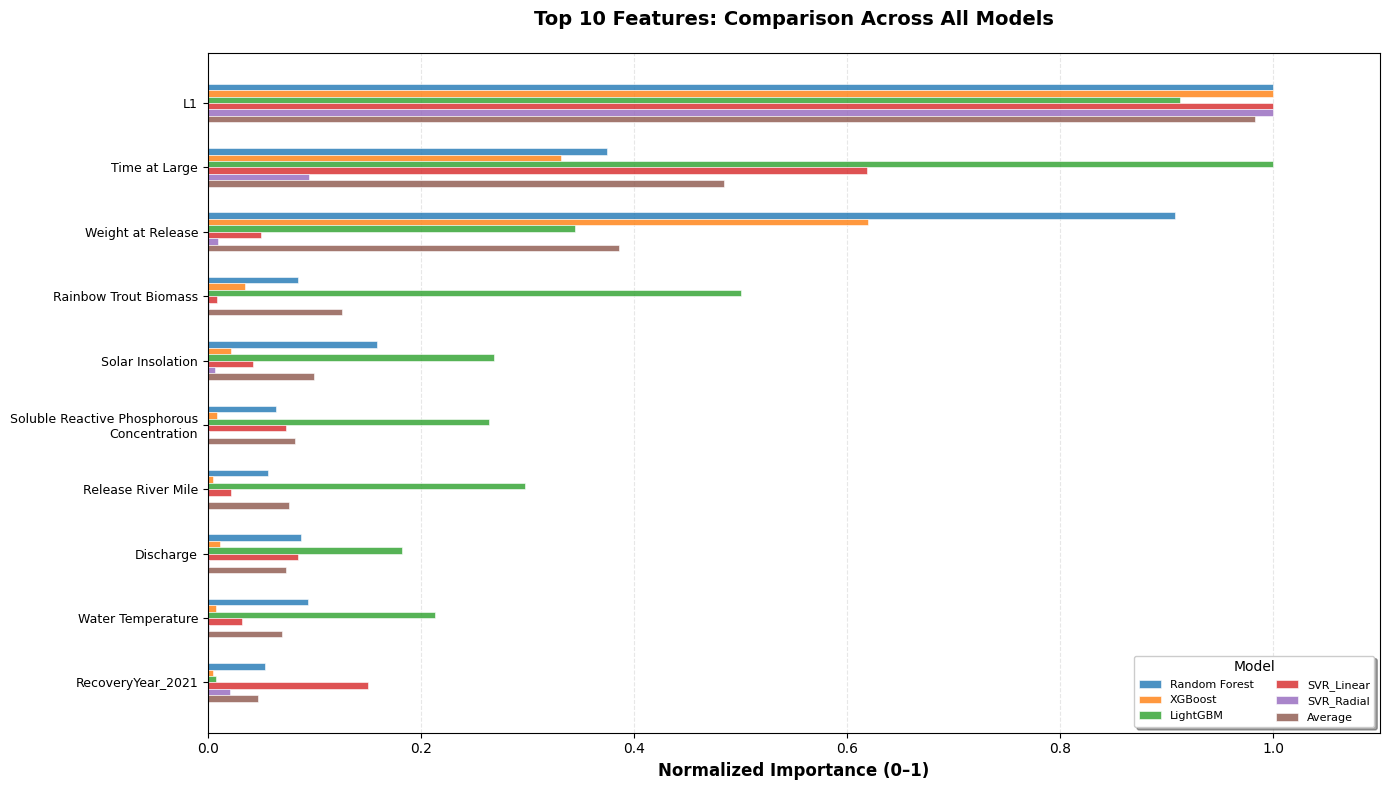


COMPREHENSIVE MODEL COEFFICIENT ANALYSIS

Detailed Comparison - Top 5 Features:

1. L1
------------------------------------------------------------
Normalized Importances:
  Random Forest       : 1.000
  XGBoost             : 1.000
  LightGBM            : 0.912
  SVR_Linear          : 1.000
  SVR_Radial          : 1.000
  Average             : 0.982

Raw Coefficients:
  SVR Linear         : 332.4929 (Positive)
  SVR RBF            : Kernel-based (no direct coefficients)

2. Time at Large
------------------------------------------------------------
Normalized Importances:
  Random Forest       : 0.374
  XGBoost             : 0.331
  LightGBM            : 1.000
  SVR_Linear          : 0.619
  SVR_Radial          : 0.095
  Average             : 0.484

Raw Coefficients:
  SVR Linear         : 205.8050 (Positive)
  SVR RBF            : Kernel-based (no direct coefficients)

3. Weight at Release
------------------------------------------------------------
Normalized Importances:
  Random Fo

In [19]:
import matplotlib.pyplot as plt
import textwrap
import numpy as np
import pandas as pd

# Display the results dataframe
highlight_df

# Number of top features to display
top_n = 10

# Step 1: Add both SVR models to importances_matrix
svr_linear_model = models["SVR_Linear"]  # Linear SVR
svr_rbf_model = models["SVR_Radial"]     # RBF SVR

# Handle Linear SVR coefficients
if svr_linear_model.kernel == 'linear':
    # Get absolute coefficients for importance magnitude
    svr_linear_coefficients = np.abs(svr_linear_model.coef_[0])
    
    # Normalize SVR Linear coefficients to [0, 1] scale like other importances
    svr_min, svr_max = svr_linear_coefficients.min(), svr_linear_coefficients.max()
    if svr_max != svr_min:
        svr_linear_normalized = (svr_linear_coefficients - svr_min) / (svr_max - svr_min)
    else:
        svr_linear_normalized = np.zeros_like(svr_linear_coefficients)
    
    # Update importances matrix with SVR Linear coefficients
    importances_matrix['SVR_Linear'] = svr_linear_normalized
    
    print(f"SVR Linear Coefficients added to importance matrix")
    print(f"SVR Linear Intercept: {svr_linear_model.intercept_[0]:.4f}")
    print(f"SVR Linear Support vectors: {svr_linear_model.n_support_[0]}")

# Handle RBF SVR permutation importance (should already be in importances_matrix from previous code)
if 'SVR_Radial' in importances_matrix.columns:
    print(f"SVR RBF permutation importance already in matrix")
    print(f"SVR RBF Intercept: {svr_rbf_model.intercept_[0]:.4f}")
    print(f"SVR RBF Support vectors: {svr_rbf_model.n_support_[0]}")
else:
    print("Warning: SVR_Radial importance not found. Run the model training loop first.")

# Step 2: Add Bayesian Linear Model coefficients
try:
    # Get Bayesian coefficients (excluding intercept)
    bayesian_coeffs = beta_mean[1:]  # Exclude intercept (first coefficient)
    
    # Normalize Bayesian coefficients to [0, 1] scale
    bayesian_abs = np.abs(bayesian_coeffs)
    bayesian_min, bayesian_max = bayesian_abs.min(), bayesian_abs.max()
    if bayesian_max != bayesian_min:
        bayesian_normalized = (bayesian_abs - bayesian_min) / (bayesian_max - bayesian_min)
    else:
        bayesian_normalized = np.zeros_like(bayesian_abs)
    
    # Add to importances matrix
    importances_matrix['Bayesian Linear'] = bayesian_normalized
    
    print(f"Bayesian Linear coefficients added to importance matrix")
    print(f"Bayesian Intercept: {beta_mean[0]:.4f}")
    print(f"Total Bayesian samples: {len(beta_mcmc)}")
    
except NameError:
    print("Bayesian model results not found. Run the Bayesian regression first.")
    print("Proceeding without Bayesian coefficients...")

# Step 3: Compute average importance and sort
avg_importance = importances_matrix.mean(axis=1)
top_features = avg_importance.sort_values(ascending=False).head(top_n).index

# Step 4: Subset importances_matrix to top features only
subset = importances_matrix.loc[top_features]

print(f"\nTop {top_n} Features by Average Importance:")
print("="*50)
for i, feature in enumerate(top_features, 1):
    avg_imp = avg_importance[feature]
    print(f"{i:2d}. {feature}: {avg_imp:.3f}")

# Step 5: Create enhanced visualization
fig, ax = plt.subplots(figsize=(14, 8))  # Even larger figure for more models
bar_height = 0.10  # Smaller bars to fit more models
index = np.arange(len(top_features))
model_names = subset.columns.tolist()

# Enhanced color palette for more models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']  
if len(model_names) > len(colors):
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))

# Plot each model's bars (horizontal)
for i, model_name in enumerate(model_names):
    ax.barh(index + i * bar_height,
            subset[model_name].values,
            bar_height,
            label=model_name,
            color=colors[i % len(colors)],
            alpha=0.8,
            edgecolor='white',
            linewidth=0.5)

# Step 6: Format y-axis labels with wrapping and larger font
wrapped_labels = ['\n'.join(textwrap.wrap(label, 35)) for label in top_features]
center_positions = index + bar_height * (len(model_names) - 1) / 2
ax.set_yticks(center_positions)
ax.set_yticklabels(wrapped_labels, fontsize=9)

# Step 7: Enhanced formatting and labels
ax.set_xlabel("Normalized Importance (0–1)", fontsize=12, fontweight='bold')
ax.set_title(f"Top {top_n} Features: Comparison Across All Models", fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()  # Highest importance at the top

# Improve legend positioning for more models
ax.legend(title="Model", fontsize=8, title_fontsize=10, 
          loc='lower right', frameon=True, fancybox=True, shadow=True,
          ncol=3 if len(model_names) > 6 else 2)

# Add grid for better readability
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Set x-axis limits for better visualization
ax.set_xlim(0, 1.1)

plt.tight_layout()
plt.savefig("comprehensive_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# Step 8: Comprehensive coefficient analysis
print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL COEFFICIENT ANALYSIS")
print(f"{'='*80}")

# Create comprehensive comparison table
comparison_data = []

for feature in top_features:
    row = {'Feature': feature}
    
    # Add each model's importance/coefficient
    for model_name in subset.columns:
        row[f'{model_name}_importance'] = subset.loc[feature, model_name]
    
    # Add raw coefficient values where available
    feature_idx = list(importances_matrix.index).index(feature)
    
    # SVR Linear raw coefficient
    if svr_linear_model.kernel == 'linear':
        row['SVR_Linear_coeff'] = svr_linear_model.coef_[0][feature_idx]
        row['SVR_Linear_impact'] = 'Positive' if svr_linear_model.coef_[0][feature_idx] > 0 else 'Negative'
    
    # SVR RBF doesn't have interpretable coefficients (kernel-based)
    row['SVR_RBF_note'] = 'Kernel-based (no direct coefficients)'
    
    # Bayesian raw coefficient with uncertainty
    try:
        bayesian_coeff = beta_mean[feature_idx + 1]  # +1 because beta_mean includes intercept
        bayesian_std = beta_mcmc[:, feature_idx + 1].std()
        bayesian_lower = np.percentile(beta_mcmc[:, feature_idx + 1], 2.5)
        bayesian_upper = np.percentile(beta_mcmc[:, feature_idx + 1], 97.5)
        
        row['Bayesian_coeff'] = bayesian_coeff
        row['Bayesian_std'] = bayesian_std
        row['Bayesian_CI_lower'] = bayesian_lower
        row['Bayesian_CI_upper'] = bayesian_upper
        
        # Determine significance
        if bayesian_lower > 0:
            row['Bayesian_impact'] = 'Positive (sig)'
        elif bayesian_upper < 0:
            row['Bayesian_impact'] = 'Negative (sig)'
        else:
            row['Bayesian_impact'] = 'Uncertain'
    except:
        pass
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Display detailed comparison for top 5 features
print(f"\nDetailed Comparison - Top 5 Features:")
print("="*100)

for i, (_, row) in enumerate(comparison_df.head(5).iterrows(), 1):
    feature_name = row['Feature']
    print(f"\n{i}. {feature_name}")
    print("-" * 60)
    
    # Show normalized importances
    print("Normalized Importances:")
    for col in comparison_df.columns:
        if col.endswith('_importance'):
            model_name = col.replace('_importance', '')
            importance = row[col]
            if not pd.isna(importance):
                print(f"  {model_name:<20}: {importance:.3f}")
    
    # Show raw coefficients with interpretation
    print("\nRaw Coefficients:")
    if 'SVR_Linear_coeff' in row and not pd.isna(row['SVR_Linear_coeff']):
        print(f"  SVR Linear         : {row['SVR_Linear_coeff']:8.4f} ({row['SVR_Linear_impact']})")
    
    print(f"  SVR RBF            : {row['SVR_RBF_note']}")
    
    if 'Bayesian_coeff' in row and not pd.isna(row['Bayesian_coeff']):
        bayesian_coeff = row['Bayesian_coeff']
        bayesian_std = row['Bayesian_std']
        bayesian_ci = f"[{row['Bayesian_CI_lower']:.3f}, {row['Bayesian_CI_upper']:.3f}]"
        print(f"  Bayesian Linear    : {bayesian_coeff:8.4f} ± {bayesian_std:.4f}")
        print(f"                       95% CI: {bayesian_ci} ({row['Bayesian_impact']})")

# Step 9: Model agreement analysis
print(f"\n{'='*60}")
print("MODEL AGREEMENT ANALYSIS")
print(f"{'='*60}")

# Calculate correlation between model importances
model_importance_cols = [col for col in comparison_df.columns if col.endswith('_importance')]
importance_matrix_clean = comparison_df[model_importance_cols].fillna(0)

if len(importance_matrix_clean.columns) > 1:
    correlation_matrix = importance_matrix_clean.corr()
    
    print("Correlation between model feature importance rankings:")
    print("-" * 55)
    
    model_names_clean = [col.replace('_importance', '') for col in importance_matrix_clean.columns]
    correlation_matrix.columns = model_names_clean
    correlation_matrix.index = model_names_clean
    
    print(correlation_matrix.round(3))
    
    # Find most/least agreed upon features
    importance_std = importance_matrix_clean.std(axis=1)
    most_agreed = comparison_df.loc[importance_std.idxmin(), 'Feature']
    least_agreed = comparison_df.loc[importance_std.idxmax(), 'Feature']
    
    print(f"\nMost agreed upon feature : {most_agreed} (std: {importance_std.min():.3f})")
    print(f"Least agreed upon feature: {least_agreed} (std: {importance_std.max():.3f})")

# Step 10: SVR Model Comparison
print(f"\n{'='*60}")
print("SVR MODEL COMPARISON")
print(f"{'='*60}")

print("Linear SVR vs RBF SVR Feature Importance Comparison:")
print("-" * 55)

if 'SVR_Linear' in subset.columns and 'SVR_Radial' in subset.columns:
    svr_comparison = pd.DataFrame({
        'Feature': top_features,
        'Linear_SVR': subset['SVR_Linear'].values,
        'RBF_SVR': subset['SVR_Radial'].values
    })
    svr_comparison['Difference'] = svr_comparison['RBF_SVR'] - svr_comparison['Linear_SVR']
    svr_comparison['Agreement'] = np.where(
        np.abs(svr_comparison['Difference']) < 0.1, 'High', 
        np.where(np.abs(svr_comparison['Difference']) < 0.3, 'Medium', 'Low')
    )
    
    print(svr_comparison[['Feature', 'Linear_SVR', 'RBF_SVR', 'Agreement']].to_string(index=False))
    
    # Correlation between the two SVR approaches
    svr_corr = svr_comparison['Linear_SVR'].corr(svr_comparison['RBF_SVR'])
    print(f"\nCorrelation between Linear and RBF SVR importance: {svr_corr:.3f}")

# Step 11: Statistical significance summary (Bayesian)
try:
    print(f"\n{'='*60}")
    print("BAYESIAN STATISTICAL SIGNIFICANCE")
    print(f"{'='*60}")
    
    print("Features with statistically significant effects (95% CI excludes 0):")
    print("-" * 70)
    
    significant_features = []
    for _, row in comparison_df.iterrows():
        if 'Bayesian_CI_lower' in row and not pd.isna(row['Bayesian_CI_lower']):
            lower = row['Bayesian_CI_lower']
            upper = row['Bayesian_CI_upper']
            
            if lower > 0 or upper < 0:  # CI doesn't include 0
                direction = "↑" if lower > 0 else "↓"
                significant_features.append((row['Feature'], direction, lower, upper))
    
    if significant_features:
        print(f"{'Feature':<40} {'Effect':<6} {'95% Credible Interval'}")
        print("-" * 70)
        for feature, direction, lower, upper in significant_features[:10]:
            feature_short = feature[:38] + '..' if len(feature) > 40 else feature
            print(f"{feature_short:<40} {direction:<6} [{lower:7.4f}, {upper:7.4f}]")
    else:
        print("No features show statistically significant effects at 95% confidence level.")
        
except:
    print("Bayesian significance analysis not available.")

print(f"\nVisualization saved as 'comprehensive_feature_importance.png'")
print("Comprehensive analysis complete!")

# Export comprehensive results
comparison_df.to_csv("comprehensive_feature_comparison.csv", index=False)
print(f"Detailed comparison exported to 'comprehensive_feature_comparison.csv'")

In [20]:
highlight_df

,Model,RMSE,MAE,R²,Adj R²,AIC,AICC,BIC
0,Baseline VBGM,86.289396,77.193476,-0.000332,-0.016589,34648.674074,34650.234239,34930.023822
1,Baseline Gompertz,86.368355,65.225730,-0.002164,-0.018451,34654.052088,34655.612254,34935.401837
2,Bayesian Linear Model,25.723943,18.547136,0.911099,0.909623,27534.200927,27535.828046,27821.536840
0,Random Forest,18.403879,12.203112,0.954496,0.953757,25563.220009,25564.780175,25844.569758
0,XGBoost,16.137178,10.722081,0.965015,0.964446,24790.378234,24791.938400,25071.727983
0,LightGBM,16.248377,10.800149,0.964531,0.963955,24830.757398,24832.317564,25112.107146
0,SVR_Linear,25.352211,15.394500,0.913650,0.912247,27446.610315,27448.170481,27727.960063
0,SVR_Radial,18.814363,11.771537,0.952444,0.951671,25692.927587,25694.487753,25974.277335


# Neural Network

## NN Estimation

Using device: cuda
Dataset split: 5486 train, 1372 validation
Batch size: 32
Model parameters: 95,553


Training:  10%|███████▏                                                                | 20/200 [00:09<01:15,  2.37it/s]

Epoch 20: Train Loss: 1039.8651, Val Loss: 402.1703, Train R²: 0.8575, Val R²: 0.9457


Training:  18%|█████████████▎                                                          | 37/200 [00:16<01:12,  2.24it/s]

Early stopping at epoch 38


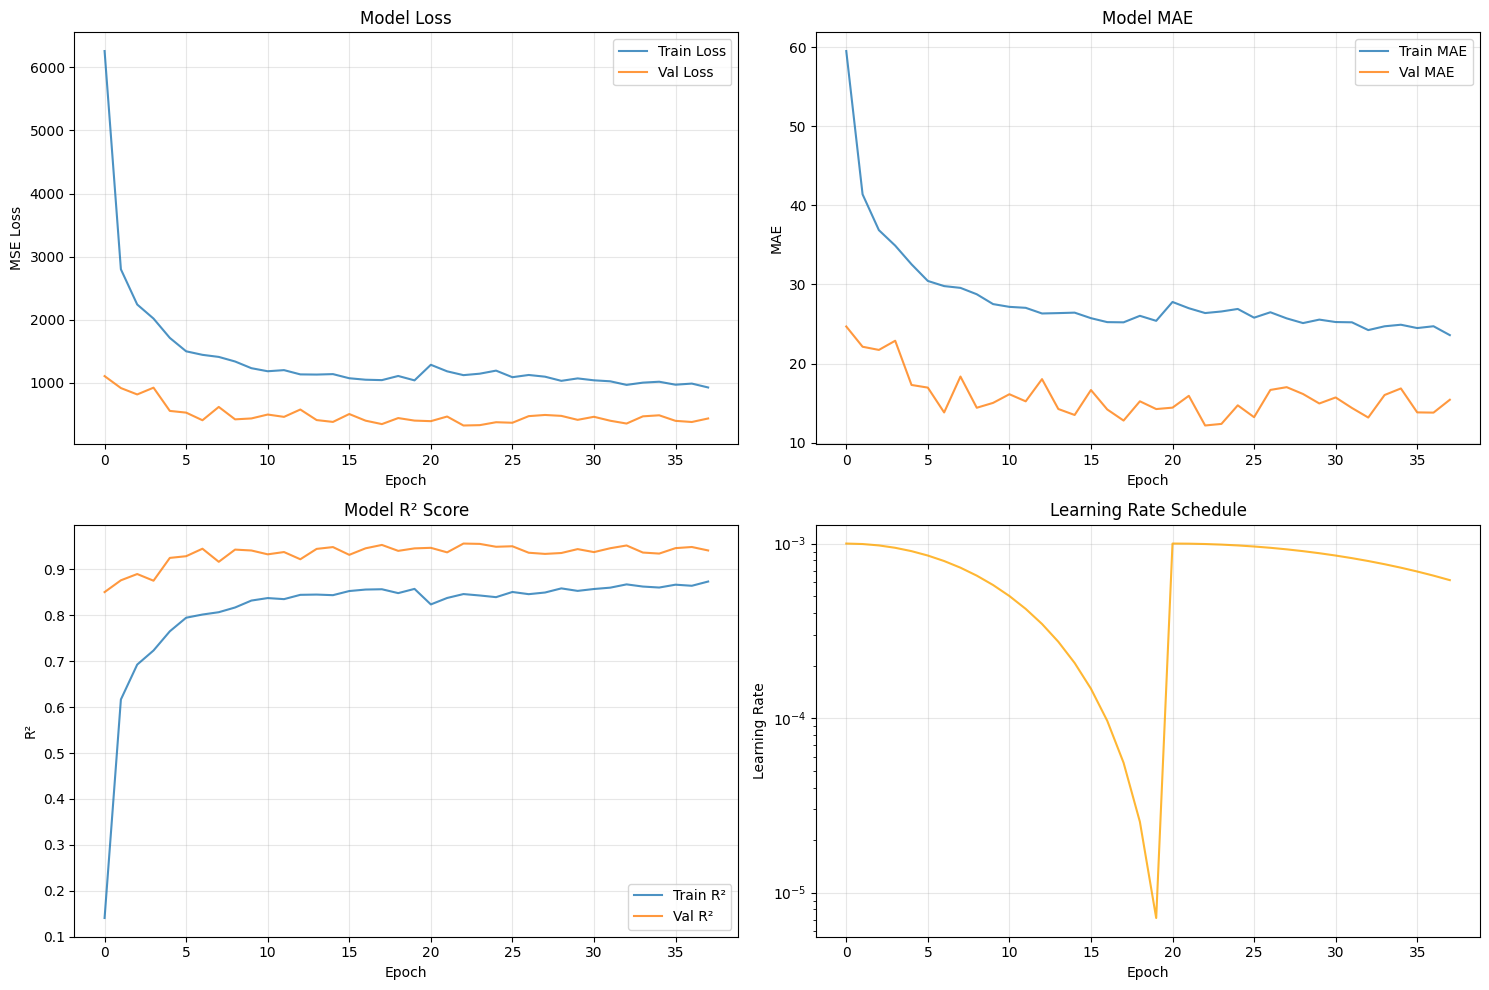


FINAL TEST RESULTS
Test RMSE: 20.7950
Test MAE:  15.2137
Test R²:   0.9419
Test MSE:  432.4333

Model predictions stored in 'L2_pred_enhancedmlp'
Enhanced PyTorch MLP training complete!


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# === OPTIMIZATION 1: Enhanced Data Preprocessing ===
def prepare_data_optimized(X_train, X_test, y_train, y_test, non_dummy_cols):
    """Enhanced data preparation with better scaling and validation"""
    
    # Scale specific columns only
    scaler = MinMaxScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    # Fit scaler on training data only
    X_train_scaled[non_dummy_cols] = scaler.fit_transform(X_train[non_dummy_cols])
    X_test_scaled[non_dummy_cols] = scaler.transform(X_test[non_dummy_cols])
    
    # Convert to tensors with proper dtype
    X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, scaler

# === OPTIMIZATION 2: Enhanced Model Architecture ===
class OptimizedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64, 32], dropout_rates=[0.3, 0.2, 0.2, 0.1]):
        super(OptimizedMLP, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        
        # Input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.input_bn = nn.BatchNorm1d(hidden_dims[0])
        self.input_dropout = nn.Dropout(dropout_rates[0])
        
        # Hidden layers with residual connections
        self.hidden_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.residual_projections = nn.ModuleList()
        
        for i in range(len(hidden_dims) - 1):
            # Main layer
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dims[i+1]))
            self.dropouts.append(nn.Dropout(dropout_rates[i+1]))
            
            # Residual projection (only if dimensions don't match)
            if hidden_dims[i] != hidden_dims[i+1]:
                self.residual_projections.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            else:
                self.residual_projections.append(nn.Identity())
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Improved weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Input layer
        x = F.silu(self.input_bn(self.input_layer(x)))
        x = self.input_dropout(x)
        
        # Hidden layers with residual connections
        for i, (layer, bn, dropout, residual) in enumerate(
            zip(self.hidden_layers, self.batch_norms, self.dropouts, self.residual_projections)
        ):
            identity = residual(x)
            x = F.silu(bn(layer(x)))
            x = dropout(x + identity)  # Residual connection
        
        # Output layer (no activation for regression)
        return self.output_layer(x)

# === OPTIMIZATION 3: Advanced Training Loop ===
def train_model_optimized(model, train_loader, val_loader, epochs=200, lr=0.001, device='cpu'):
    """Enhanced training with better monitoring and early stopping"""
    
    # Enhanced optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Cosine annealing with warm restarts
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=20, T_mult=2, eta_min=1e-6
    )
    
    criterion = nn.MSELoss()
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': [],
        'train_r2': [], 'val_r2': [], 'lr': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    patience = 15
    patience_counter = 0
    
    model.to(device)
    
    # Training loop with progress bar
    for epoch in tqdm(range(epochs), desc="Training"):
        # Training phase
        model.train()
        train_losses, train_maes, train_targets, train_preds = [], [], [], []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Collect metrics
            train_losses.append(loss.item())
            train_maes.append(F.l1_loss(output, y_batch).item())
            train_targets.extend(y_batch.cpu().numpy())
            train_preds.extend(output.detach().cpu().numpy())
        
        # Validation phase
        model.eval()
        val_losses, val_maes, val_targets, val_preds = [], [], [], []
        
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_output = model(X_val)
                val_loss = criterion(val_output, y_val)
                
                val_losses.append(val_loss.item())
                val_maes.append(F.l1_loss(val_output, y_val).item())
                val_targets.extend(y_val.cpu().numpy())
                val_preds.extend(val_output.cpu().numpy())
        
        # Calculate metrics
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_mae = np.mean(train_maes)
        val_mae = np.mean(val_maes)
        
        # R² scores
        train_r2 = r2_score(train_targets, train_preds)
        val_r2 = r2_score(val_targets, val_preds)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)
        history['train_r2'].append(train_r2)
        history['val_r2'].append(val_r2)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Learning rate scheduling
        scheduler.step()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history

# === OPTIMIZATION 4: Enhanced Visualization ===
def plot_enhanced_history(history):
    """Create comprehensive training visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plot
    axes[0,0].plot(history['train_loss'], label='Train Loss', alpha=0.8)
    axes[0,0].plot(history['val_loss'], label='Val Loss', alpha=0.8)
    axes[0,0].set_title('Model Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('MSE Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # MAE plot
    axes[0,1].plot(history['train_mae'], label='Train MAE', alpha=0.8)
    axes[0,1].plot(history['val_mae'], label='Val MAE', alpha=0.8)
    axes[0,1].set_title('Model MAE')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('MAE')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # R² plot
    axes[1,0].plot(history['train_r2'], label='Train R²', alpha=0.8)
    axes[1,0].plot(history['val_r2'], label='Val R²', alpha=0.8)
    axes[1,0].set_title('Model R² Score')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('R²')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Learning rate plot
    axes[1,1].plot(history['lr'], alpha=0.8, color='orange')
    axes[1,1].set_title('Learning Rate Schedule')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Learning Rate')
    axes[1,1].set_yscale('log')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# === MAIN EXECUTION ===

# Identify non-dummy columns
non_dummy_cols = [
    'Release River Mile', 'Time at Large', 'L1', 'Weight at Release',
    'Discharge', 'Water Temperature', 'Solar Insolation',
    'Soluble Reactive Phosphorous Concentration', 'Rainbow Trout Biomass'
]

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare data
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, scaler = prepare_data_optimized(
    X_train, X_test, y_train, y_test, non_dummy_cols
)

# Create datasets and loaders
full_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Optimized batch size based on dataset size
batch_size = min(32, len(train_dataset) // 10)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

print(f"Dataset split: {len(train_dataset)} train, {len(val_dataset)} validation")
print(f"Batch size: {batch_size}")

# Initialize model
model = OptimizedMLP(
    input_dim=X_train_tensor.shape[1],
    hidden_dims=[256, 128, 64],
    dropout_rates=[.4,.3,.2]
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Train model
model, history = train_model_optimized(
    model, train_loader, val_loader, 
    epochs=200, lr=0.001, device=device
)

# Plot training history
plot_enhanced_history(history)

# === FINAL EVALUATION ===
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred_tensor = model(X_test_device)
    y_pred = y_pred_tensor.cpu().numpy().ravel()

# Calculate comprehensive metrics
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"\n{'='*50}")
print("FINAL TEST RESULTS")
print(f"{'='*50}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE:  {test_mae:.4f}")
print(f"Test R²:   {test_r2:.4f}")
print(f"Test MSE:  {test_mse:.4f}")

# Store predictions for later comparison
L2_pred_enhancedmlp = y_pred

print(f"\nModel predictions stored in 'L2_pred_enhancedmlp'")
print("Enhanced PyTorch MLP training complete!")

## Gradient Importance

Using device: cuda
Computing Enhanced Integrated Gradients Analysis...
Computing Integrated Gradients for 200 samples...


Processing samples: 100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 214.57it/s]


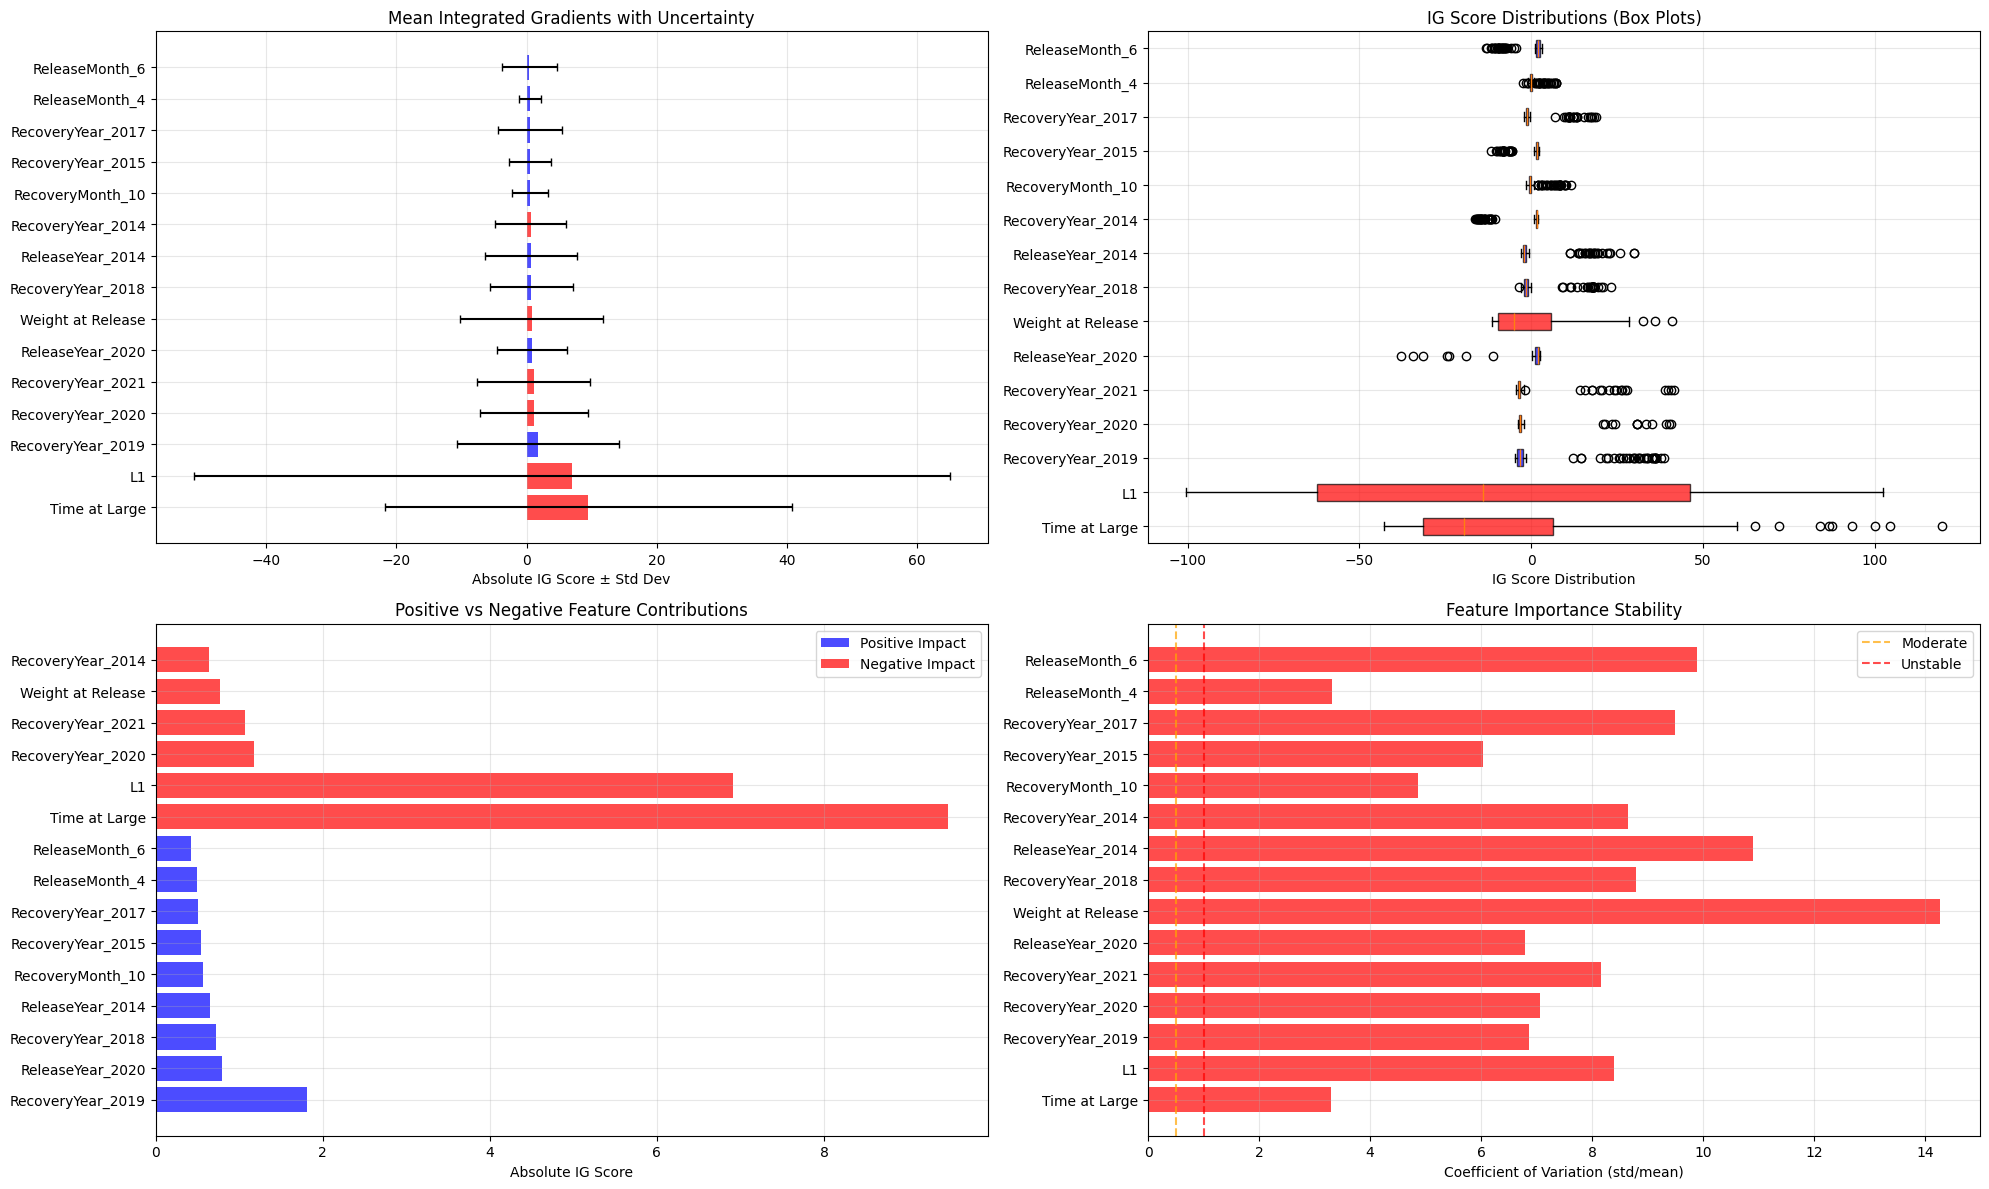


TOP 10 FEATURES BY INTEGRATED GRADIENTS
Rank Feature                                  Mean IG    Std IG     Stability   
--------------------------------------------------------------------------------
1    Time at Large                              -9.4837↓   31.2844 Unstable    
2    L1                                         -6.9136↓   58.0703 Unstable    
3    RecoveryYear_2019                           1.8112↑   12.4324 Unstable    
4    RecoveryYear_2020                          -1.1745↓    8.2933 Unstable    
5    RecoveryYear_2021                          -1.0675↓    8.7070 Unstable    
6    ReleaseYear_2020                            0.7940↑    5.3957 Unstable    
7    Weight at Release                          -0.7663↓   10.9408 Unstable    
8    RecoveryYear_2018                           0.7211↑    6.3341 Unstable    
9    ReleaseYear_2014                            0.6471↑    7.0582 Unstable    
10   RecoveryYear_2014                          -0.6353↓    5.4904 Unstable  

In [22]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# === ENHANCEMENT 1: Advanced Integrated Gradients ===
class IntegratedGradientsAnalyzer:
    def __init__(self, model, device='cpu'):
        self.model = model
        self.device = device
        self.model.to(device)
        self.model.eval()
    
    def integrated_gradients_batch(self, input_tensor, baseline=None, steps=100, batch_size=32):
        """
        Enhanced IG with batch processing for speed and better accuracy
        """
        if baseline is None:
            baseline = torch.zeros_like(input_tensor)
        
        # Move to device
        input_tensor = input_tensor.to(self.device)
        baseline = baseline.to(self.device)
        
        # Create interpolation path
        alphas = torch.linspace(0.0, 1.0, steps).to(self.device)
        
        # Process in batches for memory efficiency
        all_grads = []
        
        for i in range(0, steps, batch_size):
            batch_alphas = alphas[i:i+batch_size].view(-1, 1)
            
            # Expand for batch processing
            input_batch = input_tensor.expand(len(batch_alphas), -1)
            baseline_batch = baseline.expand(len(batch_alphas), -1)
            
            # Interpolate
            interpolated = baseline_batch + batch_alphas * (input_batch - baseline_batch)
            interpolated.requires_grad_(True)
            
            # Forward pass
            preds = self.model(interpolated)
            
            # Backward pass
            grads = torch.autograd.grad(
                outputs=preds.sum(), 
                inputs=interpolated,
                create_graph=False,
                retain_graph=False
            )[0]
            
            all_grads.append(grads.detach())
        
        # Combine all gradients
        all_grads = torch.cat(all_grads, dim=0)
        avg_grads = all_grads.mean(dim=0)
        
        # Calculate integrated gradients
        ig = (input_tensor - baseline) * avg_grads
        return ig.cpu().numpy()
    
    def compute_ig_statistics(self, X_tensor, baseline=None, n_samples=200, steps=100):
        """
        Compute IG with statistical analysis
        """
        if n_samples > len(X_tensor):
            n_samples = len(X_tensor)
        
        # Random sampling with seed for reproducibility
        np.random.seed(42)
        sample_indices = np.random.choice(len(X_tensor), size=n_samples, replace=False)
        
        # Default baseline: training mean
        if baseline is None:
            baseline = X_tensor.mean(dim=0, keepdim=True)
        
        print(f"Computing Integrated Gradients for {n_samples} samples...")
        
        all_ig = []
        for i in tqdm(sample_indices, desc="Processing samples"):
            input_sample = X_tensor[i].unsqueeze(0)
            ig = self.integrated_gradients_batch(
                input_sample, baseline=baseline, steps=steps, batch_size=32
            )
            all_ig.append(ig[0])
        
        all_ig = np.array(all_ig)
        
        # Calculate statistics
        ig_stats = {
            'mean': np.mean(all_ig, axis=0),
            'std': np.std(all_ig, axis=0),
            'median': np.median(all_ig, axis=0),
            'q25': np.percentile(all_ig, 25, axis=0),
            'q75': np.percentile(all_ig, 75, axis=0),
            'min': np.min(all_ig, axis=0),
            'max': np.max(all_ig, axis=0),
            'raw_scores': all_ig
        }
        
        return ig_stats
    
    def sensitivity_analysis(self, input_tensor, feature_names, perturbation_size=0.1):
        """
        Perform sensitivity analysis by perturbing features
        """
        baseline_pred = self.model(input_tensor.to(self.device)).item()
        sensitivities = []
        
        for i in range(input_tensor.shape[1]):
            # Perturb feature i
            perturbed = input_tensor.clone()
            perturbed[0, i] += perturbation_size
            
            perturbed_pred = self.model(perturbed.to(self.device)).item()
            sensitivity = abs(perturbed_pred - baseline_pred)
            sensitivities.append(sensitivity)
        
        return np.array(sensitivities)

# === ENHANCEMENT 2: Comprehensive Visualization ===
def create_comprehensive_ig_plots(ig_stats, feature_names, top_n=15):
    """
    Create enhanced visualization with error bars and statistical information
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # Prepare data
    ig_mean = ig_stats['mean']
    ig_std = ig_stats['std']
    ig_median = ig_stats['median']
    
    # Sort by absolute mean importance
    importance_order = np.argsort(np.abs(ig_mean))[::-1]
    top_indices = importance_order[:top_n]
    
    top_features = [feature_names[i] for i in top_indices]
    top_means = ig_mean[top_indices]
    top_stds = ig_std[top_indices]
    top_medians = ig_median[top_indices]
    
    # 1. Mean IG with error bars
    colors = ['red' if x < 0 else 'blue' for x in top_means]
    axes[0,0].barh(range(len(top_features)), np.abs(top_means), 
                   xerr=top_stds, color=colors, alpha=0.7, capsize=3)
    axes[0,0].set_yticks(range(len(top_features)))
    axes[0,0].set_yticklabels([f[:30] + '...' if len(f) > 30 else f for f in top_features])
    axes[0,0].set_xlabel('Absolute IG Score ± Std Dev')
    axes[0,0].set_title('Mean Integrated Gradients with Uncertainty')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Box plot of IG distributions
    raw_scores = ig_stats['raw_scores'][:, top_indices]
    box_data = [raw_scores[:, i] for i in range(len(top_indices))]
    
    bp = axes[0,1].boxplot(box_data, labels=range(len(top_features)), 
                          patch_artist=True, vert=False)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[0,1].set_yticklabels([f[:25] + '...' if len(f) > 25 else f for f in top_features])
    axes[0,1].set_xlabel('IG Score Distribution')
    axes[0,1].set_title('IG Score Distributions (Box Plots)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Positive vs Negative contributions
    positive_mask = top_means > 0
    pos_features = np.array(top_features)[positive_mask]
    pos_scores = top_means[positive_mask]
    neg_features = np.array(top_features)[~positive_mask]
    neg_scores = np.abs(top_means[~positive_mask])
    
    if len(pos_features) > 0:
        axes[1,0].barh(range(len(pos_features)), pos_scores, 
                      color='blue', alpha=0.7, label='Positive Impact')
    if len(neg_features) > 0:
        axes[1,0].barh(range(len(pos_features), len(pos_features) + len(neg_features)), 
                      neg_scores, color='red', alpha=0.7, label='Negative Impact')
    
    all_feature_labels = list(pos_features) + list(neg_features)
    axes[1,0].set_yticks(range(len(all_feature_labels)))
    axes[1,0].set_yticklabels([f[:30] + '...' if len(f) > 30 else f for f in all_feature_labels])
    axes[1,0].set_xlabel('Absolute IG Score')
    axes[1,0].set_title('Positive vs Negative Feature Contributions')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Coefficient of variation (stability measure)
    cv = top_stds / np.abs(top_means)  # Coefficient of variation
    stability_colors = ['green' if x < 0.5 else 'orange' if x < 1.0 else 'red' for x in cv]
    
    axes[1,1].barh(range(len(top_features)), cv, color=stability_colors, alpha=0.7)
    axes[1,1].set_yticks(range(len(top_features)))
    axes[1,1].set_yticklabels([f[:30] + '...' if len(f) > 30 else f for f in top_features])
    axes[1,1].set_xlabel('Coefficient of Variation (std/mean)')
    axes[1,1].set_title('Feature Importance Stability')
    axes[1,1].axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='Moderate')
    axes[1,1].axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='Unstable')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# === ENHANCEMENT 3: Model-Agnostic Analysis ===
def compare_attribution_methods(model, X_tensor, feature_names, baseline=None):
    """
    Compare IG with other attribution methods
    """
    analyzer = IntegratedGradientsAnalyzer(model, device=X_tensor.device)
    
    # Sample for comparison
    sample_input = X_tensor[0].unsqueeze(0)
    
    # 1. Integrated Gradients
    ig_scores = analyzer.integrated_gradients_batch(sample_input, baseline=baseline)
    
    # 2. Simple Gradients
    sample_input.requires_grad_(True)
    pred = model(sample_input)
    simple_grads = torch.autograd.grad(pred, sample_input)[0]
    simple_grads = simple_grads.detach().cpu().numpy()[0]
    
    # 3. Sensitivity Analysis
    sensitivity_scores = analyzer.sensitivity_analysis(sample_input, feature_names)
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Feature': feature_names,
        'Integrated_Gradients': np.abs(ig_scores[0]),
        'Simple_Gradients': np.abs(simple_grads),
        'Sensitivity_Analysis': sensitivity_scores
    })
    
    # Normalize for comparison
    for col in ['Integrated_Gradients', 'Simple_Gradients', 'Sensitivity_Analysis']:
        comparison_df[f'{col}_norm'] = (comparison_df[col] - comparison_df[col].min()) / \
                                     (comparison_df[col].max() - comparison_df[col].min())
    
    return comparison_df

# === MAIN EXECUTION ===

# Setup
#device = torch.device('dml')
print(f"Using device: {device}")

# Prepare data (assuming model and data are available)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
feature_names = X_test_scaled.columns.tolist()

# Create analyzer
analyzer = IntegratedGradientsAnalyzer(model, device=device)

# Compute baseline (training mean)
baseline_vec = X_train_tensor.mean(dim=0, keepdim=True)

print("Computing Enhanced Integrated Gradients Analysis...")

# === COMPREHENSIVE IG ANALYSIS ===
ig_stats = analyzer.compute_ig_statistics(
    X_test_tensor, 
    baseline=baseline_vec, 
    n_samples=200,  # Increased sample size
    steps=150       # Increased steps for better accuracy
)

# Create comprehensive visualizations
fig = create_comprehensive_ig_plots(ig_stats, feature_names, top_n=15)
plt.savefig('enhanced_integrated_gradients_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# === DETAILED RESULTS TABLE ===
ig_results_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_IG': ig_stats['mean'],
    'Std_IG': ig_stats['std'],
    'Median_IG': ig_stats['median'],
    'Q25_IG': ig_stats['q25'],
    'Q75_IG': ig_stats['q75'],
    'Coefficient_of_Variation': ig_stats['std'] / np.abs(ig_stats['mean']),
    'Abs_Mean_IG': np.abs(ig_stats['mean'])
})

# Sort by absolute importance
ig_results_df = ig_results_df.sort_values('Abs_Mean_IG', ascending=False)

print("\n" + "="*80)
print("TOP 10 FEATURES BY INTEGRATED GRADIENTS")
print("="*80)
print(f"{'Rank':<4} {'Feature':<40} {'Mean IG':<10} {'Std IG':<10} {'Stability':<12}")
print("-" * 80)

for i, (_, row) in enumerate(ig_results_df.head(10).iterrows(), 1):
    feature_name = row['Feature'][:38] + '..' if len(row['Feature']) > 40 else row['Feature']
    mean_ig = row['Mean_IG']
    std_ig = row['Std_IG']
    cv = row['Coefficient_of_Variation']
    
    if cv < 0.5:
        stability = "Stable"
    elif cv < 1.0:
        stability = "Moderate"
    else:
        stability = "Unstable"
    
    direction = "↑" if mean_ig > 0 else "↓"
    
    print(f"{i:<4} {feature_name:<40} {mean_ig:>9.4f}{direction} {std_ig:>9.4f} {stability:<12}")

# === ATTRIBUTION METHOD COMPARISON ===
print("\n" + "="*60)
print("ATTRIBUTION METHOD COMPARISON")
print("="*60)

comparison_df = compare_attribution_methods(model, X_test_tensor, feature_names, baseline_vec)

# Show correlation between methods
print("\nCorrelation between attribution methods:")
corr_matrix = comparison_df[['Integrated_Gradients_norm', 'Simple_Gradients_norm', 'Sensitivity_Analysis_norm']].corr()
print(corr_matrix.round(3))

# === EXPORT RESULTS ===
ig_results_df.to_csv('enhanced_integrated_gradients_results.csv', index=False)
comparison_df.to_csv('attribution_methods_comparison.csv', index=False)

print(f"\nResults exported to:")
print(f"- enhanced_integrated_gradients_results.csv")
print(f"- attribution_methods_comparison.csv")
print(f"- enhanced_integrated_gradients_analysis.png")

print("\nEnhanced Integrated Gradients analysis complete!")

## Updated Importance Plots

Current columns in importances_matrix:
 1. Random Forest
 2. XGBoost
 3. LightGBM
 4. SVR_Linear
 5. SVR_Radial
 6. Average

Renamed columns: {'SVR_Linear': 'SVR Linear', 'SVR_Radial': 'SVR RBF'}
Bayesian model not available (beta_mean not found)
Added Neural Network IG model
VBGM model not available: name 'idata' is not defined
Gompertz model not available: name 'idata_gomp' is not defined

Top 10 Features by Average Importance:
 1. L1: 0.946
 2. Time at Large: 0.558
 3. Weight at Release: 0.343
 4. Rainbow Trout Biomass: 0.109
 5. Solar Insolation: 0.087
 6. Soluble Reactive Phosphorous Concentration: 0.073
 7. Release River Mile: 0.067
 8. Discharge: 0.065
 9. Water Temperature: 0.062
10. RecoveryYear_2021: 0.057

Final models included (7 total):
 1. Random Forest
 2. XGBoost
 3. LightGBM
 4. SVR Linear
 5. SVR RBF
 6. Average
 7. Neural Network IG


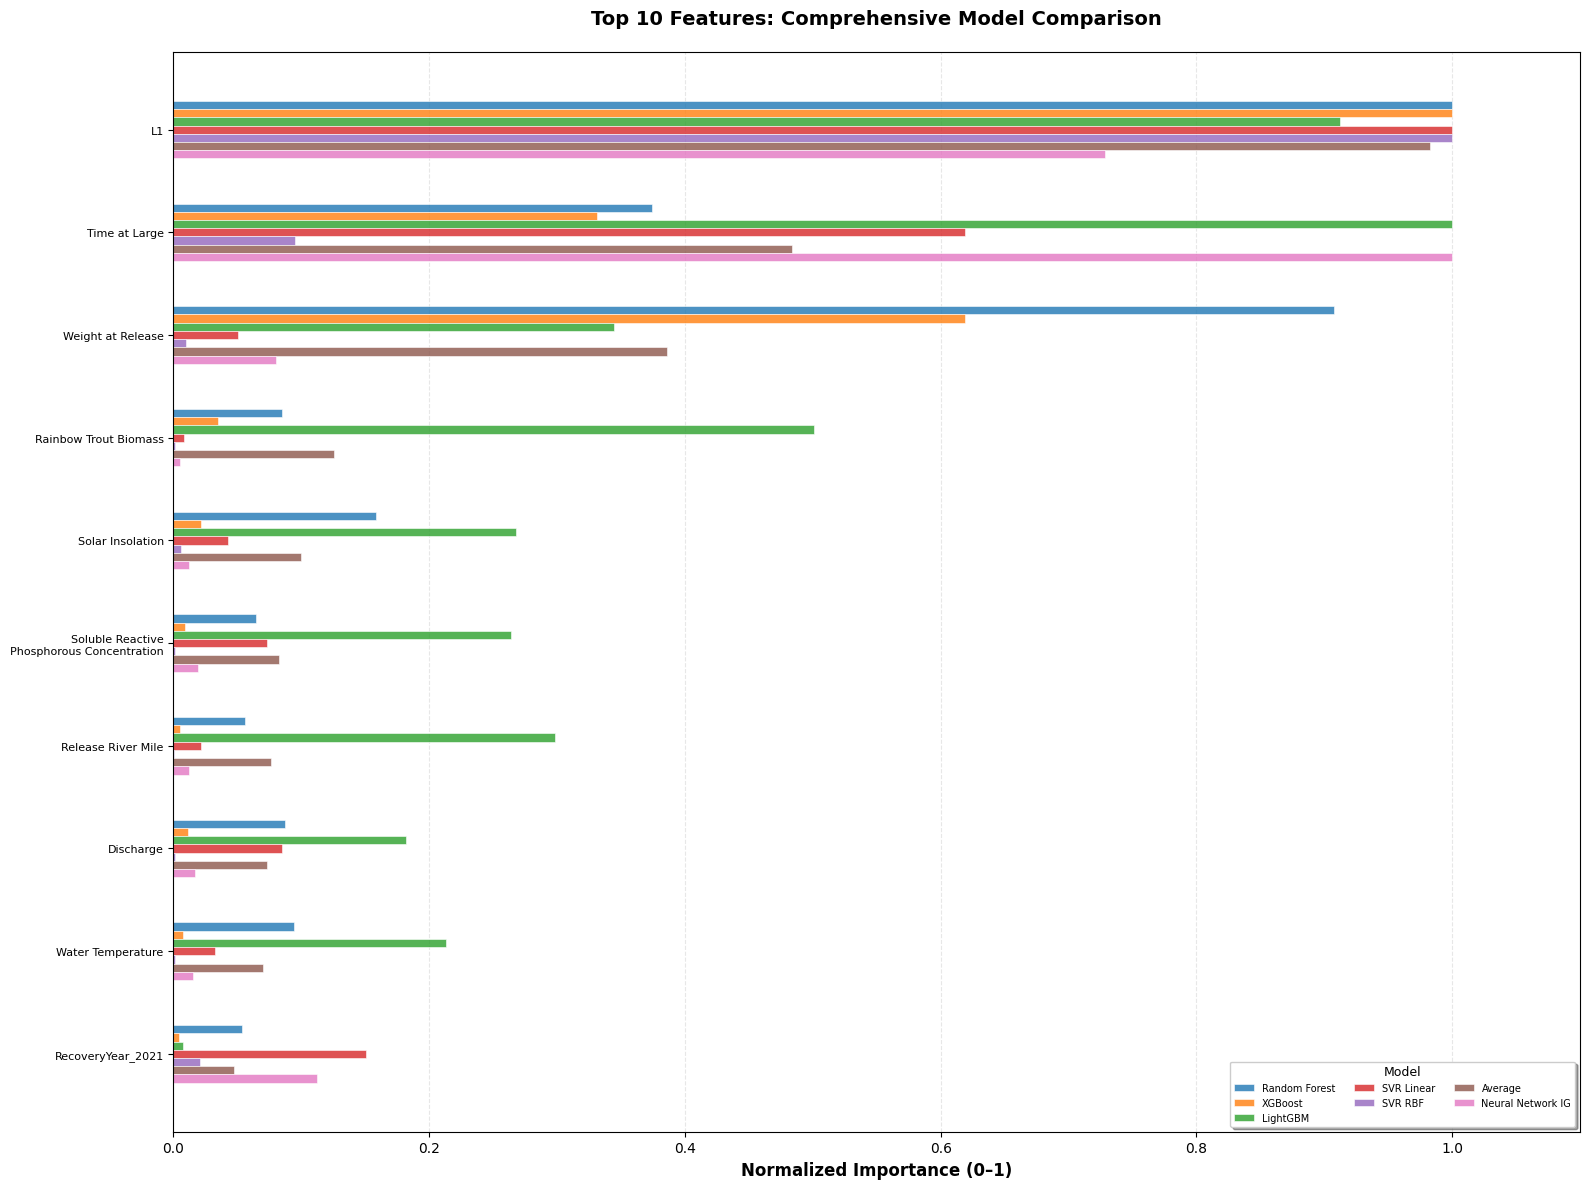


Results exported to: feature_importance_comparison.csv
Analysis complete!


In [23]:
import matplotlib.pyplot as plt
import textwrap
import numpy as np
import pandas as pd

# Number of top features to display
top_n = 10

# Step 1: Check what we have in importances_matrix
print("Current columns in importances_matrix:")
for i, col in enumerate(importances_matrix.columns, 1):
    print(f"{i:2d}. {col}")

# Step 2: Ensure SVR RBF column exists (calculate if missing)
if 'SVR_Radial' not in importances_matrix.columns and 'SVR RBF' not in importances_matrix.columns:
    print("\nSVR_Radial column not found. Calculating from trained model...")
    
    # Get the trained SVR_Radial model
    svr_rbf_model = models["SVR_Radial"]
    
    # Calculate permutation importance for RBF SVR
    from sklearn.inspection import permutation_importance
    
    print("  Using permutation importance for RBF SVR...")
    perm_importance = permutation_importance(
        svr_rbf_model, 
        X_test_scaled, 
        y_test, 
        n_repeats=10,
        random_state=42,
        scoring='neg_mean_squared_error'
    )
    
    raw_importances = perm_importance.importances_mean
    
    # Normalize importances to [0, 1] scale
    imp_min, imp_max = raw_importances.min(), raw_importances.max()
    if imp_max != imp_min:
        norm_importances = (raw_importances - imp_min) / (imp_max - imp_min)
    else:
        norm_importances = np.zeros_like(raw_importances)
    
    # Add to importances matrix
    importances_matrix['SVR_Radial'] = norm_importances
    print(f"  SVR_Radial importance calculated and added")

# Step 3: Standardize column names for display
column_mapping = {}
for col in importances_matrix.columns:
    if col == 'SVR_Linear':
        column_mapping[col] = 'SVR Linear'
    elif col == 'SVR_Radial':
        column_mapping[col] = 'SVR RBF'
    elif 'SVR' in col and 'Linear' in col:
        column_mapping[col] = 'SVR Linear'
    elif 'SVR' in col and ('RBF' in col or 'Radial' in col):
        column_mapping[col] = 'SVR RBF'

# Rename columns
if column_mapping:
    importances_matrix = importances_matrix.rename(columns=column_mapping)
    print(f"\nRenamed columns: {column_mapping}")

# Step 4: Add other models if available
models_to_add = []

# Bayesian Linear Model
try:
    bayesian_coeffs = beta_mean[1:]  # Exclude intercept
    bayesian_abs = np.abs(bayesian_coeffs)
    bayesian_min, bayesian_max = bayesian_abs.min(), bayesian_abs.max()
    if bayesian_max != bayesian_min:
        bayesian_normalized = (bayesian_abs - bayesian_min) / (bayesian_max - bayesian_min)
    else:
        bayesian_normalized = np.zeros_like(bayesian_abs)
    
    importances_matrix['Bayesian Linear'] = bayesian_normalized
    models_to_add.append('Bayesian Linear')
    print(f"Added Bayesian Linear model")
except NameError:
    print("Bayesian model not available (beta_mean not found)")

# Neural Network IG
try:
    ig_scores = ig_results_df.set_index('Feature')['Abs_Mean_IG']
    ig_aligned = ig_scores.reindex(importances_matrix.index, fill_value=0)
    ig_min, ig_max = ig_aligned.min(), ig_aligned.max()
    if ig_max != ig_min:
        ig_normalized = (ig_aligned - ig_min) / (ig_max - ig_min)
    else:
        ig_normalized = pd.Series(np.zeros_like(ig_aligned), index=ig_aligned.index)
    
    importances_matrix['Neural Network IG'] = ig_normalized
    models_to_add.append('Neural Network IG')
    print(f"Added Neural Network IG model")
except NameError:
    print("Neural Network IG not available (ig_results_df not found)")

# VBGM Bayesian
try:
    # Check what variables are available in idata
    print(f"VBGM idata variables: {list(idata.posterior.data_vars)}")
    
    vbgm_beta_samples = idata.posterior['beta'].values.reshape(-1, idata.posterior['beta'].shape[-1])
    vbgm_beta_mean = vbgm_beta_samples.mean(axis=0)
    vbgm_abs_importance = np.abs(vbgm_beta_mean)
    vbgm_min, vbgm_max = vbgm_abs_importance.min(), vbgm_abs_importance.max()
    if vbgm_max != vbgm_min:
        vbgm_normalized = (vbgm_abs_importance - vbgm_min) / (vbgm_max - vbgm_min)
    else:
        vbgm_normalized = np.zeros_like(vbgm_abs_importance)
    
    vbgm_features = importances_matrix.index.difference(["L1", "Time at Large"])
    vbgm_series = pd.Series(0.0, index=importances_matrix.index)
    vbgm_series.loc[vbgm_features] = vbgm_normalized
    importances_matrix['VBGM Bayesian'] = vbgm_series
    models_to_add.append('VBGM Bayesian')
    print(f"Added VBGM Bayesian model")
except (NameError, KeyError) as e:
    print(f"VBGM model not available: {e}")

# Gompertz Bayesian
try:
    # Check what variables are available in idata_gomp
    print(f"Gompertz idata variables: {list(idata_gomp.posterior.data_vars)}")
    
    gompertz_beta_samples = idata_gomp.posterior['beta'].values.reshape(-1, idata_gomp.posterior['beta'].shape[-1])
    gompertz_beta_mean = gompertz_beta_samples.mean(axis=0)
    gompertz_abs_importance = np.abs(gompertz_beta_mean)
    gompertz_min, gompertz_max = gompertz_abs_importance.min(), gompertz_abs_importance.max()
    if gompertz_max != gompertz_min:
        gompertz_normalized = (gompertz_abs_importance - gompertz_min) / (gompertz_max - gompertz_min)
    else:
        gompertz_normalized = np.zeros_like(gompertz_abs_importance)
    
    gompertz_features = importances_matrix.index.difference(["L1", "Time at Large"])
    gompertz_series = pd.Series(0.0, index=importances_matrix.index)
    gompertz_series.loc[gompertz_features] = gompertz_normalized
    importances_matrix['Gompertz Bayesian'] = gompertz_series
    models_to_add.append('Gompertz Bayesian')
    print(f"Added Gompertz Bayesian model")
except (NameError, KeyError) as e:
    print(f"Gompertz model not available: {e}")

# Step 5: Compute average importance and get top features
avg_importance = importances_matrix.mean(axis=1)
top_features = avg_importance.sort_values(ascending=False).head(top_n).index
subset = importances_matrix.loc[top_features]

print(f"\nTop {top_n} Features by Average Importance:")
print("="*60)
for i, feature in enumerate(top_features, 1):
    avg_imp = avg_importance[feature]
    print(f"{i:2d}. {feature}: {avg_imp:.3f}")

# Step 6: Create visualization
print(f"\nFinal models included ({len(subset.columns)} total):")
for i, col in enumerate(subset.columns, 1):
    print(f"{i:2d}. {col}")

fig, ax = plt.subplots(figsize=(16, 12))
bar_height = 0.08
index = np.arange(len(top_features))
model_names = subset.columns.tolist()

# Color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#17becf', '#bcbd22']
if len(model_names) > len(colors):
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))

# Plot bars
for i, model_name in enumerate(model_names):
    ax.barh(index + i * bar_height,
            subset[model_name].values,
            bar_height,
            label=model_name,
            color=colors[i % len(colors)],
            alpha=0.8,
            edgecolor='white',
            linewidth=0.5)

# Formatting
wrapped_labels = ['\n'.join(textwrap.wrap(label, 25)) for label in top_features]
center_positions = index + bar_height * (len(model_names) - 1) / 2
ax.set_yticks(center_positions)
ax.set_yticklabels(wrapped_labels, fontsize=8)

ax.set_xlabel("Normalized Importance (0–1)", fontsize=12, fontweight='bold')
ax.set_title(f"Top {top_n} Features: Comprehensive Model Comparison", 
             fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()

# Legend
ncols = min(3, len(model_names))
ax.legend(title="Model", fontsize=7, title_fontsize=9, 
          loc='lower right', frameon=True, fancybox=True, shadow=True,
          ncol=ncols)

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.set_xlim(0, 1.1)

plt.tight_layout()
plt.savefig("comprehensive_feature_importance_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Step 7: Export results
subset.to_csv('feature_importance_comparison.csv')
print(f"\nResults exported to: feature_importance_comparison.csv")
print("Analysis complete!")

## NN Predictions

In [24]:
import torch

# Load the trained model
#model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Convert test data to torch tensor
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)

# Predict
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()

# Store reshaped prediction as L2 equivalent
L2_pred_nn = y_pred.reshape(-1, 1).ravel()


## NN Metrics

In [25]:
# Estimate number of parameters 

k_params = min(sum(p.numel() for p in model.parameters() if p.requires_grad), 2 * X_test.shape[1])


# Compute metrics
nn_metrics = get_model_metrics(
    y_true=y_test,
    y_pred=L2_pred_nn,
    model_name="ANN",
    k_params=k_params
)

# Append to the highlight table
highlight_df = pd.concat([highlight_df, nn_metrics], ignore_index=True)

# Show the updated table
display(highlight_df)


,Model,RMSE,MAE,R²,Adj R²,AIC,AICC,BIC
0,Baseline VBGM,86.289396,77.193476,-0.000332,-0.016589,34648.674074,34650.234239,34930.023822
1,Baseline Gompertz,86.368355,65.225730,-0.002164,-0.018451,34654.052088,34655.612254,34935.401837
2,Bayesian Linear Model,25.723943,18.547136,0.911099,0.909623,27534.200927,27535.828046,27821.536840
3,Random Forest,18.403879,12.203112,0.954496,0.953757,25563.220009,25564.780175,25844.569758
4,XGBoost,16.137178,10.722081,0.965015,0.964446,24790.378234,24791.938400,25071.727983
5,LightGBM,16.248377,10.800149,0.964531,0.963955,24830.757398,24832.317564,25112.107146
6,SVR_Linear,25.352211,15.394500,0.913650,0.912247,27446.610315,27448.170481,27727.960063
7,SVR_Radial,18.814363,11.771537,0.952444,0.951671,25692.927587,25694.487753,25974.277335
8,ANN,20.795031,15.213675,0.941904,0.939984,26375.477351,26381.755031,26938.176848


##  NN Diagram

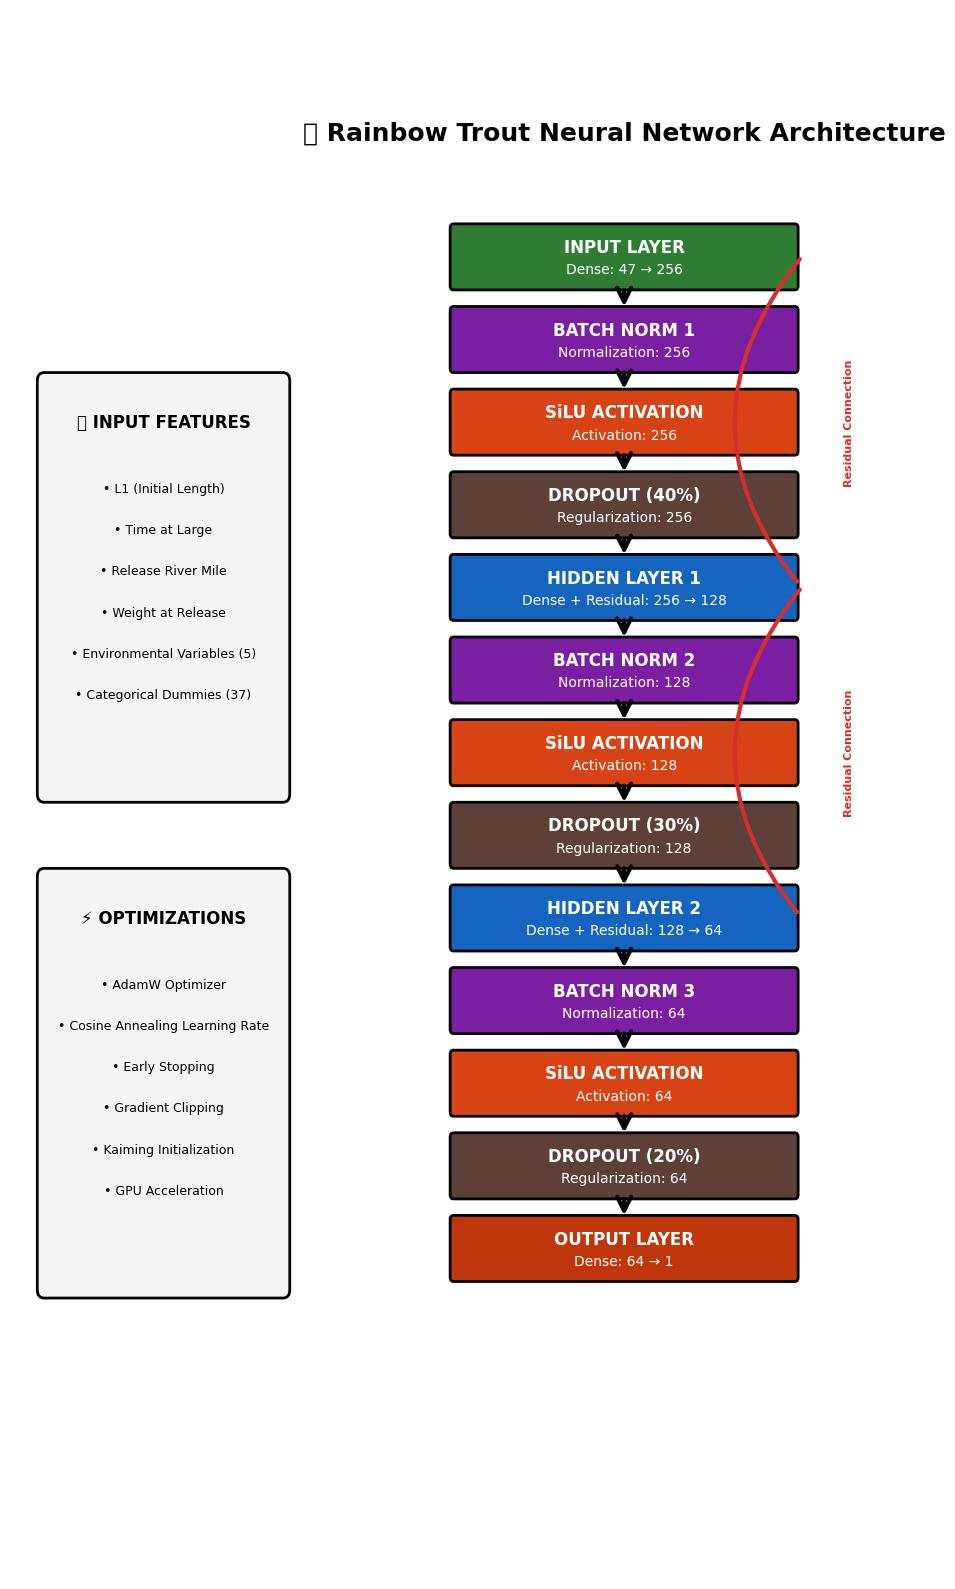

🎨 Accessible neural network architecture diagram created!
📁 Saved as: accessible_neural_network.png

♿ Accessibility Improvements:
- High contrast colors (WCAG AA compliant)
- Colorblind-friendly palette
- Larger, bolder text
- Black borders and arrows for maximum visibility
- Increased spacing between elements
- White background for optimal contrast

🏗️ Architecture Summary:
- Input: 47 features
- Hidden: 256 → 128 → 64 neurons
- Output: 1 neuron (regression)
- Regularization: BatchNorm + Dropout + Residual connections
- Activation: SiLU (Swish)
- Optimizer: AdamW with Cosine Annealing Learning Rate


In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, ConnectionPatch
import numpy as np

# Create figure with increased height, reduced width
fig, ax = plt.subplots(1, 1, figsize=(10, 16))

# Accessible color scheme with high contrast
# Using colorblind-friendly palette with WCAG AA compliant contrast ratios
colors = {
    'input': '#2E7D32',      # Dark Green
    'hidden': '#1565C0',     # Dark Blue  
    'batch_norm': '#7B1FA2', # Dark Purple
    'activation': '#D84315',  # Dark Orange-Red
    'dropout': '#5D4037',    # Dark Brown
    'output': '#BF360C',     # Dark Red-Orange
    'background': '#FFFFFF'  # White background for maximum contrast
}

# Set background
ax.set_facecolor(colors['background'])

# Layer specifications
layers = [
    {'name': 'INPUT LAYER', 'type': 'Dense', 'neurons': '47 → 256', 'color': colors['input']},
    {'name': 'BATCH NORM 1', 'type': 'Normalization', 'neurons': '256', 'color': colors['batch_norm']},
    {'name': 'SiLU ACTIVATION', 'type': 'Activation', 'neurons': '256', 'color': colors['activation']},
    {'name': 'DROPOUT (40%)', 'type': 'Regularization', 'neurons': '256', 'color': colors['dropout']},
    {'name': 'HIDDEN LAYER 1', 'type': 'Dense + Residual', 'neurons': '256 → 128', 'color': colors['hidden']},
    {'name': 'BATCH NORM 2', 'type': 'Normalization', 'neurons': '128', 'color': colors['batch_norm']},
    {'name': 'SiLU ACTIVATION', 'type': 'Activation', 'neurons': '128', 'color': colors['activation']},
    {'name': 'DROPOUT (30%)', 'type': 'Regularization', 'neurons': '128', 'color': colors['dropout']},
    {'name': 'HIDDEN LAYER 2', 'type': 'Dense + Residual', 'neurons': '128 → 64', 'color': colors['hidden']},
    {'name': 'BATCH NORM 3', 'type': 'Normalization', 'neurons': '64', 'color': colors['batch_norm']},
    {'name': 'SiLU ACTIVATION', 'type': 'Activation', 'neurons': '64', 'color': colors['activation']},
    {'name': 'DROPOUT (20%)', 'type': 'Regularization', 'neurons': '64', 'color': colors['dropout']},
    {'name': 'OUTPUT LAYER', 'type': 'Dense', 'neurons': '64 → 1', 'color': colors['output']}
]

# Layout parameters - increased height spacing, further reduced box width
y_start = 14
y_spacing = 1.0
box_width = 5
box_height = 0.7
x_center = 5

# Draw layers
layer_positions = []
for i, layer in enumerate(layers):
    y_pos = y_start - i * y_spacing
    
    # Create fancy box with higher contrast border
    box = FancyBboxPatch(
        (x_center - box_width/2, y_pos - box_height/2),
        box_width, box_height,
        boxstyle="round,pad=0.05",
        facecolor=layer['color'],
        edgecolor='#000000',  # Black border for maximum contrast
        linewidth=2,
        alpha=1.0  # Full opacity for better contrast
    )
    ax.add_patch(box)
    
    # Add text with white color for contrast against dark backgrounds
    ax.text(x_center, y_pos + 0.12, layer['name'], 
            ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    ax.text(x_center, y_pos - 0.15, f"{layer['type']}: {layer['neurons']}", 
            ha='center', va='center', fontsize=10, color='white', fontweight='normal')
    
    layer_positions.append((x_center, y_pos))

# Draw arrows between layers with higher contrast
for i in range(len(layer_positions) - 1):
    start_pos = layer_positions[i]
    end_pos = layer_positions[i + 1]
    
    arrow = ConnectionPatch(
        (start_pos[0], start_pos[1] - box_height/2 - 0.05),
        (end_pos[0], end_pos[1] + box_height/2 + 0.05),
        "data", "data",
        arrowstyle="->",
        shrinkA=0, shrinkB=0,
        mutation_scale=25,  # Larger arrows for better visibility
        color='#000000',    # Black arrows for maximum contrast
        linewidth=3,        # Thicker lines
        alpha=1.0
    )
    ax.add_patch(arrow)

# Add residual connection indicators with proper arrows from boxes
residual_layers = [4, 8]  # Hidden layers with residual connections
residual_inputs = [0, 4]  # Corresponding input layers for residual connections

for i, layer_idx in enumerate(residual_layers):
    input_layer_idx = residual_inputs[i]
    
    start_y = layer_positions[input_layer_idx][1]  # Position of input layer
    end_y = layer_positions[layer_idx][1]         # Position of target layer
    
    # Draw curved arrow from input layer to target layer
    residual_arrow = patches.FancyArrowPatch(
        (x_center + box_width/2 + 0.1, start_y),      # Start from right edge of input layer
        (x_center + box_width/2 + 0.1, end_y),        # End at right edge of target layer
        arrowstyle="->",
        connectionstyle="arc3,rad=0.4",               # Curved connection
        color='#D32F2F',    # High contrast red
        linewidth=3,
        alpha=1.0
    )
    ax.add_patch(residual_arrow)
    
    # Add label for residual connection
    mid_y = (start_y + end_y) / 2
    ax.text(x_center + box_width/2 + 0.8, mid_y, 'Residual Connection', 
            ha='center', va='center', fontsize=8, color='#D32F2F', 
            fontweight='bold', rotation=90)

# Title with high contrast
ax.text(x_center, 15.5, '🐟 Rainbow Trout Neural Network Architecture', 
        ha='center', va='center', fontsize=18, fontweight='bold', color='#000000')

# Feature box on the left with accessible colors
features_y = 10
features_box = FancyBboxPatch(
    (-3.5, features_y - 2.5), 3.5, 5,
    boxstyle="round,pad=0.1",
    facecolor='#F5F5F5',
    edgecolor='#000000',
    linewidth=2
)
ax.add_patch(features_box)

ax.text(-1.75, features_y + 2, '🔢 INPUT FEATURES', 
        ha='center', va='center', fontsize=12, fontweight='bold', color='#000000')

input_features = [
    "• L1 (Initial Length)",
    "• Time at Large", 
    "• Release River Mile",
    "• Weight at Release",
    "• Environmental Variables (5)",
    "• Categorical Dummies (37)"
]

for i, feature in enumerate(input_features):
    ax.text(-1.75, features_y + 1.2 - i*0.5, feature, 
            ha='center', va='center', fontsize=9, color='#000000')

# Optimization box below the features box
opt_y = 4
opt_box = FancyBboxPatch(
    (-3.5, opt_y - 2.5), 3.5, 5,
    boxstyle="round,pad=0.1",
    facecolor='#F5F5F5',
    edgecolor='#000000',
    linewidth=2
)
ax.add_patch(opt_box)

ax.text(-1.75, opt_y + 2, '⚡ OPTIMIZATIONS', 
        ha='center', va='center', fontsize=12, fontweight='bold', color='#000000')

optimizations = [
    "• AdamW Optimizer",
    "• Cosine Annealing Learning Rate",
    "• Early Stopping",
    "• Gradient Clipping", 
    "• Kaiming Initialization",
    "• GPU Acceleration"
]

for i, opt in enumerate(optimizations):
    ax.text(-1.75, opt_y + 1.2 - i*0.5, opt, 
            ha='center', va='center', fontsize=9, color='#000000')

# Set axis limits and remove axes
ax.set_xlim(-4, 9)
ax.set_ylim(-2, 17)
ax.axis('off')

# Add subtle grid for better structure (very light)
ax.grid(True, alpha=0.05, linestyle='--', color='#000000')

plt.tight_layout()
plt.savefig('accessible_neural_network.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("🎨 Accessible neural network architecture diagram created!")
print("📁 Saved as: accessible_neural_network.png")
print("\n♿ Accessibility Improvements:")
print("- High contrast colors (WCAG AA compliant)")
print("- Colorblind-friendly palette")
print("- Larger, bolder text")
print("- Black borders and arrows for maximum visibility")
print("- Increased spacing between elements")
print("- White background for optimal contrast")
print("\n🏗️ Architecture Summary:")
print("- Input: 47 features")
print("- Hidden: 256 → 128 → 64 neurons")
print("- Output: 1 neuron (regression)")
print("- Regularization: BatchNorm + Dropout + Residual connections")
print("- Activation: SiLU (Swish)")
print("- Optimizer: AdamW with Cosine Annealing Learning Rate")

# Biological Models

We model L2 for consistency across models.

## 🐟 Bayesian Fabens Growth Model

We estimate the posterior distribution of the parameters $L_\infty$, $k$, and $\sigma$ using Bayesian inference, given tag-recapture data:

- $L_1$: Length at release  
- $L_2$: Length at recapture  
- $\Delta t$: Time at large (in years)

---

### 📌 Full Posterior

$$
\begin{aligned}
p(&L_\infty, k, \sigma_{\text{obs}}, \sigma_{L_\infty} \mid L_1, \Delta t, L_2) = \\
&\frac{
    \underbrace{p(L_2 \mid L_1, \Delta t, L_\infty, k, \sigma_{\text{obs}})}_{\text{Likelihood}} \cdot
    \underbrace{p(L_\infty \mid \sigma_{L_\infty})}_{\text{Hierarchical Normal prior}} \cdot
    \underbrace{p(k)}_{\text{HalfNormal prior}} \cdot
    \underbrace{p(\sigma_{\text{obs}})}_{\text{HalfNormal}} \cdot
    \underbrace{p(\sigma_{L_\infty})}_{\text{HalfNormal}}
}{
    \int \cdots \int \text{same terms}\ dL_\infty\, dk\, d\sigma_{\text{obs}}\, d\sigma_{L_\infty}
}
\end{aligned}
$$

---

### 🔢 Likelihood

$$
L_2 \sim \mathcal{N} \left( L_\infty - (L_\infty - L_1) e^{-k \Delta t},\ \sigma_{\text{obs}}^2 \right)
$$

---

### 🎲 Priors

- $\sigma_{\text{obs}} \sim \mathrm{HalfNormal}(2)$  
- $\sigma_{L_\infty} \sim \mathrm{HalfNormal}(2)$  
- $L_\infty \sim \mathcal{N}(500,\ \sigma_{L_\infty}^2)$  
- $k \sim \mathrm{HalfNormal}(1)$





## Fabens VBGM Estimation



In [27]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import random
from sklearn.preprocessing import MinMaxScaler
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

# Set platform for speed
numpyro.set_platform("gpu") 
numpyro.set_host_device_count(4)  # Enable parallel chains

# === STEP 1: Extract biological variables ===
bio_vars = ["L1", "Time at Large"]
X_train_bio = X_train_scaled_partial[bio_vars].copy()
X_test_bio = X_test_scaled_partial[bio_vars].copy()

# Convert L1 (mm → cm) and cast to JAX arrays
L1_cm = jnp.array((X_train_bio["L1"].values / 10.0).astype(np.float32))  # float32
L1_test_cm = jnp.array((X_test_bio["L1"].values / 10.0).astype(np.float32))

# Convert dt (Time at Large) to JAX arrays
dt = jnp.array(X_train_bio["Time at Large"].values.astype(np.float32))
dt_test = jnp.array(X_test_bio["Time at Large"].values.astype(np.float32))

# Convert L2 (response) from mm → cm
y = jnp.array((y_train.values / 10.0).astype(np.float32))
y_test_cm = jnp.array((y_test.values / 10.0).astype(np.float32))

# === STEP 2: Prepare scaled predictors (drop biologicals first) ===
X_train_predictors = X_train_scaled_partial.drop(columns=bio_vars)
X_test_predictors = X_test_scaled_partial.drop(columns=bio_vars)

X = jnp.array(X_train_predictors.values.astype(np.float32))
X_test = jnp.array(X_test_predictors.values.astype(np.float32))

# === STEP 3: Define NumPyro VBGM model ===
def vbgm_model(dt, L1, X, L2=None):
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfNormal(2.0))
    sigma_Linf = numpyro.sample("sigma_Linf", dist.HalfNormal(2.0))
    L_inf = numpyro.sample("L_inf", dist.Normal(5.0, sigma_Linf))
    alpha_k = numpyro.sample("alpha_k", dist.Normal(0.0, 1.0))
    beta = numpyro.sample("beta", dist.Normal(0.0, 0.5).expand([X.shape[1]]))
    
    linear_k = alpha_k + jnp.dot(X, beta)
    k = jnp.exp(linear_k)
    L2_hat = L_inf - (L_inf - L1) * jnp.exp(-k * dt)
    
    numpyro.sample("obs", dist.Normal(L2_hat, sigma_obs), obs=L2)

# === STEP 4: Run MCMC ===
rng_key = random.PRNGKey(42)
kernel = NUTS(vbgm_model, target_accept_prob=0.9)  # Higher acceptance for efficiency
mcmc = MCMC(kernel, num_warmup=500, num_samples=1500, num_chains=4)  # Reduced iterations
mcmc.run(rng_key, dt=dt, L1=L1_cm, X=X, L2=y)
mcmc.print_summary()

# === STEP 5: Diagnostics ===
idata = az.from_numpyro(mcmc)
print(az.summary(idata, var_names=["~obs"]))

sample: 100%|███████████████████████████| 2000/2000 [00:45<00:00, 43.55it/s, 127 steps of size 2.28e-02. acc. prob=0.92]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       L_inf     35.32      0.18     35.32     35.02     35.62   4058.36      1.00
     alpha_k     -6.37      0.24     -6.37     -6.75     -5.95   1813.71      1.00
     beta[0]     -0.90      0.12     -0.90     -1.10     -0.71   8209.22      1.00
     beta[1]     -1.02      0.13     -1.01     -1.23     -0.81   7002.74      1.00
     beta[2]     -0.13      0.16     -0.13     -0.39      0.12   1447.64      1.00
     beta[3]     -0.05      0.17     -0.05     -0.31      0.23   1541.58      1.00
     beta[4]      0.07      0.16      0.07     -0.19      0.33   1500.76      1.00
     beta[5]     -0.08      0.16     -0.08     -0.33      0.17   1466.09      1.00
     beta[6]     -0.28      0.16     -0.28     -0.54     -0.03   1458.16      1.00
     beta[7]     -0.20      0.16     -0.19     -0.46      0.08   1560.66      1.00
     beta[8]     -0.21      0.16     -0.21     -0.47      0.04   1451.94      1.00
   

## VBGM Posterior Diagnostics

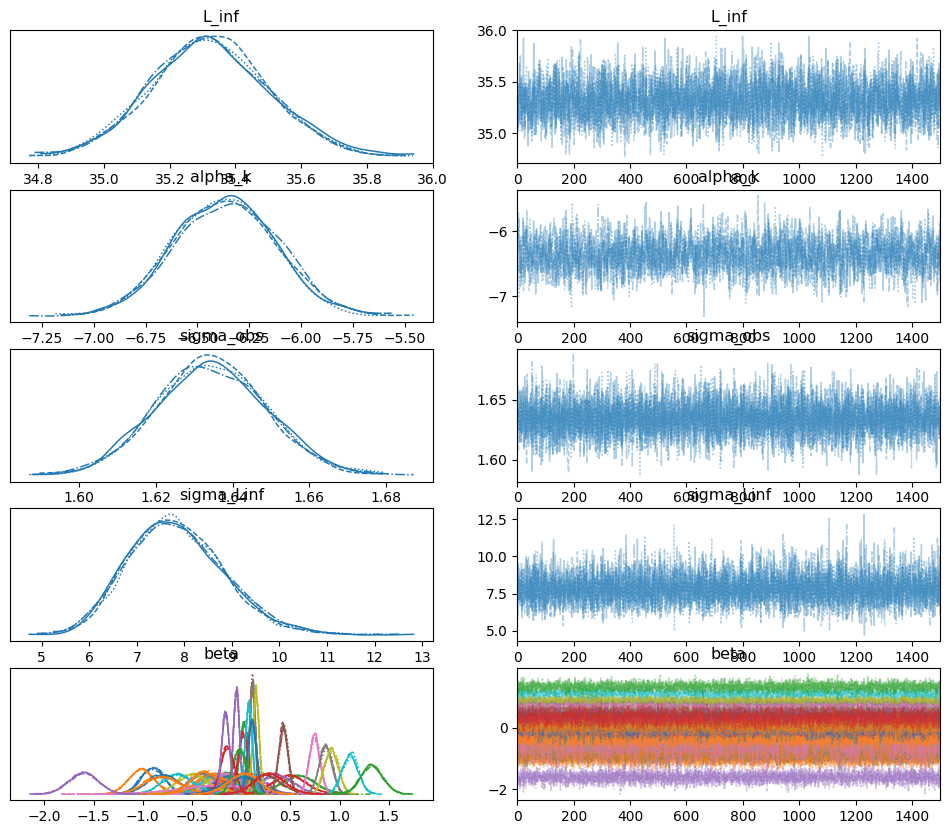

In [29]:
az.plot_trace(idata, var_names=["L_inf", "alpha_k", "sigma_obs", "sigma_Linf", "beta"])

# === Step 10: Posterior predictive on test set
predictive = Predictive(vbgm_model, posterior_samples=mcmc.get_samples(), return_sites=["obs"])
preds = predictive(rng_key, dt=dt_test, L1=L1_test_cm, X=X_test)
L2_pred = jnp.mean(preds["obs"], axis=0)


## Divergences

In [30]:
print("Num divergences:", idata.sample_stats["diverging"].sum().item())

Num divergences: 0


## VBGM Metrics

In [31]:
from numpyro.infer import Predictive

predictive = Predictive(
    vbgm_model,
    posterior_samples=mcmc.get_samples(),
    return_sites=["obs"]
)

# Run posterior predictive on test set
preds = predictive(random.PRNGKey(123), dt=dt_test, L1=L1_test_cm, X=X_test)

# Take the mean across all posterior samples
L2_pred_vbgm = jnp.mean(preds["obs"], axis=0)


# Use your unified metrics function
vbgm_metrics = get_model_metrics(
    y_true=y_test_cm*10,
    y_pred=L2_pred_vbgm*10,
    k_params=3,
    model_name="Bayesian VBGM"
)

highlight_df = pd.concat([highlight_df, vbgm_metrics])
highlight_df



,Model,RMSE,MAE,R²,Adj R²,AIC,AICC,BIC
0,Baseline VBGM,86.289396,77.193476,-0.000332,-0.016589,34648.674074,34650.234239,34930.023822
1,Baseline Gompertz,86.368355,65.225730,-0.002164,-0.018451,34654.052088,34655.612254,34935.401837
2,Bayesian Linear Model,25.723943,18.547136,0.911099,0.909623,27534.200927,27535.828046,27821.536840
3,Random Forest,18.403879,12.203112,0.954496,0.953757,25563.220009,25564.780175,25844.569758
4,XGBoost,16.137178,10.722081,0.965015,0.964446,24790.378234,24791.938400,25071.727983
5,LightGBM,16.248377,10.800149,0.964531,0.963955,24830.757398,24832.317564,25112.107146
6,SVR_Linear,25.352211,15.394500,0.913650,0.912247,27446.610315,27448.170481,27727.960063
7,SVR_Radial,18.814363,11.771537,0.952444,0.951671,25692.927587,25694.487753,25974.277335
8,ANN,20.795031,15.213675,0.941904,0.939984,26375.477351,26381.755031,26938.176848
0,Bayesian VBGM,16.817428,11.599745,0.962003,0.961964,24945.163648,24945.171822,24963.122143


## Table

In [32]:
predictor_columns = [
    'Release River Mile',
    'Weight at Release',
    'ReleaseMonth_1', 'ReleaseMonth_2', 'ReleaseMonth_3', 'ReleaseMonth_4',
    'ReleaseMonth_6', 'ReleaseMonth_7', 'ReleaseMonth_9', 'ReleaseMonth_10',
    'ReleaseMonth_11', 'ReleaseMonth_12',
    'ReleaseYear_2012', 'ReleaseYear_2013', 'ReleaseYear_2014',
    'ReleaseYear_2015', 'ReleaseYear_2016', 'ReleaseYear_2017',
    'ReleaseYear_2018', 'ReleaseYear_2019', 'ReleaseYear_2020', 'ReleaseYear_2021',
    'RecoveryMonth_2', 'RecoveryMonth_3', 'RecoveryMonth_4',
    'RecoveryMonth_6', 'RecoveryMonth_7', 'RecoveryMonth_9', 'RecoveryMonth_10',
    'RecoveryMonth_11', 'RecoveryMonth_12',
    'RecoveryYear_2012', 'RecoveryYear_2013', 'RecoveryYear_2014',
    'RecoveryYear_2015', 'RecoveryYear_2017', 'RecoveryYear_2018',
    'RecoveryYear_2019', 'RecoveryYear_2020', 'RecoveryYear_2021',
    'Discharge', 'Water Temperature', 'Solar Insolation',
    'Soluble Reactive Phosphorous Concentration', 'Rainbow Trout Biomass'
]


summary = az.summary(idata, var_names=["~obs"])

# Apply the beta-to-variable renaming
beta_map = {f"beta[{i}]": predictor_columns[i] for i in range(len(predictor_columns))}
summary.index = summary.index.to_series().replace(beta_map)

summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L_inf,35.323,0.179,34.985,35.659,0.003,0.002,4090.0,4416.0,1.0
alpha_k,-6.367,0.245,-6.830,-5.925,0.006,0.003,1839.0,3073.0,1.0
Release River Mile,-0.901,0.120,-1.139,-0.684,0.001,0.002,8249.0,4461.0,1.0
Weight at Release,-1.016,0.126,-1.251,-0.780,0.002,0.002,7032.0,4848.0,1.0
ReleaseMonth_1,-0.131,0.158,-0.418,0.166,0.004,0.003,1458.0,2555.0,1.0
ReleaseMonth_2,-0.048,0.165,-0.356,0.262,0.004,0.002,1563.0,2902.0,1.0
ReleaseMonth_3,0.069,0.162,-0.245,0.356,0.004,0.003,1508.0,2498.0,1.0
ReleaseMonth_4,-0.083,0.157,-0.384,0.203,0.004,0.003,1475.0,2438.0,1.0
ReleaseMonth_6,-0.283,0.158,-0.562,0.031,0.004,0.003,1467.0,2543.0,1.0
ReleaseMonth_7,-0.196,0.164,-0.502,0.116,0.004,0.003,1577.0,2768.0,1.0


# Bayesian Gompertz Model

## 🐟 Bayesian Gompertz Growth Model

We estimate the posterior distribution of the parameters $L_\infty$, $k$, and $\sigma$ using Bayesian inference, given tag-recapture data:

- $L_1$: Length at release  
- $L_2$: Length at recapture  
- $\Delta t$: Time at large (in years)

---

### 📌 Full Posterior

$$
\begin{aligned}
p(&L_\infty, k, \sigma_{\text{obs}}, \sigma_{L_\infty} \mid L_1, \Delta t, L_2) = \\
&\frac{
  \underbrace{p(L_2 \mid L_1, \Delta t, L_\infty, k, \sigma_{\text{obs}})}_{\text{Likelihood}} \cdot
  \underbrace{p(L_\infty \mid \sigma_{L_\infty})}_{\text{Hierarchical prior}} \cdot
  \underbrace{p(k)}_{\text{Prior}} \cdot
  \underbrace{p(\sigma_{\text{obs}})}_{\text{Prior}} \cdot
  \underbrace{p(\sigma_{L_\infty})}_{\text{Prior}}
}{
  \int \cdots \int \text{same terms} \ dL_\infty\, dk\, d\sigma_{\text{obs}}\, d\sigma_{L_\infty}
}
\end{aligned}
$$

---

### 🔢 Likelihood

$$
L_2 \sim \mathcal{N} \left( L_\infty \cdot \exp\left[ \ln\left(\frac{L_1}{L_\infty} \right) \cdot e^{-k \Delta t} \right],\ \sigma_{\text{obs}}^2 \right)
$$

---

### 🎲 Priors

- $ \sigma_{\text{obs}} \sim \text{HalfNormal}(2) $  
- $ \sigma_{L_\infty} \sim \text{HalfNormal}(2) $  
- $ L_\infty \sim \mathcal{N}(500,\ \sigma_{L_\infty}^2) $  
- $ k \sim \text{HalfNormal}(1) $

---


## GM Estimation

In [33]:
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import jax.numpy as jnp
import numpyro
import arviz as az
from jax import random

# Set platform for speed
numpyro.set_platform("gpu")  # or "gpu" if available
numpyro.set_host_device_count(4)  # Enable parallel chains

# === STEP 1: Use partial scaled data ===
bio_vars = ["L1", "Time at Large"]
X_train_bio = X_train_scaled_partial[bio_vars].copy()
X_test_bio = X_test_scaled_partial[bio_vars].copy()

# Convert L1 (mm → cm) and Time at Large to JAX arrays
L1_cm = jnp.array((X_train_bio["L1"].values / 10.0).astype(np.float32))  # float32
L1_test_cm = jnp.array((X_test_bio["L1"].values / 10.0).astype(np.float32))
dt = jnp.array(X_train_bio["Time at Large"].values.astype(np.float32))
dt_test = jnp.array(X_test_bio["Time at Large"].values.astype(np.float32))

# Convert L2 (response) from mm → cm
y = jnp.array((y_train.values / 10.0).astype(np.float32))
y_test_cm = jnp.array((y_test.values / 10.0).astype(np.float32))

# === STEP 2: Prepare predictors (excluding bio variables) ===
X_train_predictors = X_train_scaled_partial.drop(columns=bio_vars)
X_test_predictors = X_test_scaled_partial.drop(columns=bio_vars)
X = jnp.array(X_train_predictors.values.astype(np.float32))
X_test = jnp.array(X_test_predictors.values.astype(np.float32))

# === Define Gompertz Model in cm ===
def gompertz_model(dt, L1, X, L2=None):
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfNormal(2.0))
    sigma_Linf = numpyro.sample("sigma_Linf", dist.HalfNormal(2.0))
    L_inf = numpyro.sample("L_inf", dist.Normal(5.0, sigma_Linf))
    alpha_k = numpyro.sample("alpha_k", dist.Normal(0.0, 1.0))
    beta = numpyro.sample("beta", dist.Normal(0.0, 0.5).expand([X.shape[1]]))
    
    linear_k = alpha_k + jnp.dot(X, beta)
    k = jnp.exp(linear_k)
    log_ratio = jnp.log(jnp.maximum(L1 / L_inf, 1e-6))  # Prevent log(0)
    L2_hat = L_inf * jnp.exp(log_ratio * jnp.exp(-k * dt))
    
    numpyro.sample("obs", dist.Normal(L2_hat, sigma_obs), obs=L2)

# === Run MCMC ===
rng_key = random.PRNGKey(84)
kernel = NUTS(gompertz_model, target_accept_prob=0.9)  # Reduced from 0.95 for speed
mcmc_gomp = MCMC(kernel, num_warmup=500, num_samples=1500, num_chains=4)  # Reduced iterations
mcmc_gomp.run(rng_key, dt=dt, L1=L1_cm, X=X, L2=y)
mcmc_gomp.print_summary()

# === Convert to ArviZ and summarize ===
idata_gomp = az.from_numpyro(mcmc_gomp)
az.summary(idata_gomp, var_names=["~obs"])

sample: 100%|███████████████████████████| 2000/2000 [01:00<00:00, 33.08it/s, 511 steps of size 1.78e-02. acc. prob=0.94]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       L_inf     35.32      0.21     35.31     34.98     35.64   3772.41      1.00
     alpha_k     -5.71      0.24     -5.71     -6.12     -5.33   1589.85      1.00
     beta[0]     -0.81      0.10     -0.81     -0.98     -0.64   7895.78      1.00
     beta[1]     -2.59      0.13     -2.59     -2.81     -2.38   5519.94      1.00
     beta[2]     -0.16      0.16     -0.16     -0.42      0.09   1387.85      1.00
     beta[3]     -0.06      0.16     -0.06     -0.33      0.21   1471.24      1.00
     beta[4]      0.02      0.16      0.02     -0.25      0.27   1467.19      1.00
     beta[5]     -0.10      0.16     -0.10     -0.36      0.15   1399.58      1.00
     beta[6]     -0.27      0.16     -0.27     -0.53     -0.02   1412.33      1.00
     beta[7]     -0.22      0.16     -0.21     -0.47      0.05   1446.74      1.00
     beta[8]     -0.15      0.16     -0.15     -0.40      0.11   1403.30      1.00
   

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L_inf,35.321,0.206,34.955,35.722,0.003,0.002,3785.0,4157.0,1.0
alpha_k,-5.709,0.240,-6.154,-5.260,0.006,0.003,1599.0,2946.0,1.0
beta[0],-0.811,0.105,-1.004,-0.613,0.001,0.001,7916.0,4179.0,1.0
beta[1],-2.593,0.131,-2.841,-2.344,0.002,0.002,5709.0,4307.0,1.0
beta[2],-0.160,0.156,-0.449,0.133,0.004,0.003,1397.0,2251.0,1.0
beta[3],-0.060,0.162,-0.349,0.258,0.004,0.003,1481.0,2348.0,1.0
beta[4],0.016,0.158,-0.276,0.320,0.004,0.003,1480.0,2128.0,1.0
beta[5],-0.100,0.156,-0.391,0.195,0.004,0.003,1411.0,2180.0,1.0
beta[6],-0.273,0.156,-0.567,0.019,0.004,0.003,1420.0,2258.0,1.0
beta[7],-0.217,0.161,-0.496,0.110,0.004,0.003,1454.0,2498.0,1.0


## GM Posterior Diagnostics

In [34]:
import arviz as az
idata_gomp = az.from_numpyro(mcmc_gomp)

## Gompertz & Total Metrics

In [35]:
from numpyro.infer import Predictive

predictive = Predictive(
    gompertz_model,
    posterior_samples=mcmc_gomp.get_samples(),
    return_sites=["obs"]
)

# Run posterior predictive on test set
preds = predictive(random.PRNGKey(123), dt=dt_test, L1=L1_test_cm, X=X_test)

# Take the mean across all posterior samples
L2_pred_gomp = jnp.mean(preds["obs"], axis=0)


# Use your unified metrics function
gompertz_metrics = get_model_metrics(
    y_true=y_test_cm*10,
    y_pred=L2_pred_gomp*10,
    k_params=3,
    model_name="Bayesian Gompertz"
)

highlight_df = pd.concat([highlight_df, gompertz_metrics])
highlight_df



,Model,RMSE,MAE,R²,Adj R²,AIC,AICC,BIC
0,Baseline VBGM,86.289396,77.193476,-0.000332,-0.016589,34648.674074,34650.234239,34930.023822
1,Baseline Gompertz,86.368355,65.225730,-0.002164,-0.018451,34654.052088,34655.612254,34935.401837
2,Bayesian Linear Model,25.723943,18.547136,0.911099,0.909623,27534.200927,27535.828046,27821.536840
3,Random Forest,18.403879,12.203112,0.954496,0.953757,25563.220009,25564.780175,25844.569758
4,XGBoost,16.137178,10.722081,0.965015,0.964446,24790.378234,24791.938400,25071.727983
5,LightGBM,16.248377,10.800149,0.964531,0.963955,24830.757398,24832.317564,25112.107146
6,SVR_Linear,25.352211,15.394500,0.913650,0.912247,27446.610315,27448.170481,27727.960063
7,SVR_Radial,18.814363,11.771537,0.952444,0.951671,25692.927587,25694.487753,25974.277335
8,ANN,20.795031,15.213675,0.941904,0.939984,26375.477351,26381.755031,26938.176848
0,Bayesian VBGM,16.817428,11.599745,0.962003,0.961964,24945.163648,24945.171822,24963.122143


## Table

In [36]:
predictor_columns = [
    'Release River Mile',
    'Weight at Release',
    'ReleaseMonth_1', 'ReleaseMonth_2', 'ReleaseMonth_3', 'ReleaseMonth_4',
    'ReleaseMonth_6', 'ReleaseMonth_7', 'ReleaseMonth_9', 'ReleaseMonth_10',
    'ReleaseMonth_11', 'ReleaseMonth_12',
    'ReleaseYear_2012', 'ReleaseYear_2013', 'ReleaseYear_2014',
    'ReleaseYear_2015', 'ReleaseYear_2016', 'ReleaseYear_2017',
    'ReleaseYear_2018', 'ReleaseYear_2019', 'ReleaseYear_2020', 'ReleaseYear_2021',
    'RecoveryMonth_2', 'RecoveryMonth_3', 'RecoveryMonth_4',
    'RecoveryMonth_6', 'RecoveryMonth_7', 'RecoveryMonth_9', 'RecoveryMonth_10',
    'RecoveryMonth_11', 'RecoveryMonth_12',
    'RecoveryYear_2012', 'RecoveryYear_2013', 'RecoveryYear_2014',
    'RecoveryYear_2015', 'RecoveryYear_2017', 'RecoveryYear_2018',
    'RecoveryYear_2019', 'RecoveryYear_2020', 'RecoveryYear_2021',
    'Discharge', 'Water Temperature', 'Solar Insolation',
    'Soluble Reactive Phosphorous Concentration', 'Rainbow Trout Biomass'
]


summary = az.summary(idata_gomp, var_names=["~obs"])

# Apply the beta-to-variable renaming
beta_map = {f"beta[{i}]": predictor_columns[i] for i in range(len(predictor_columns))}
summary.index = summary.index.to_series().replace(beta_map)

summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L_inf,35.321,0.206,34.955,35.722,0.003,0.002,3785.0,4157.0,1.0
alpha_k,-5.709,0.240,-6.154,-5.260,0.006,0.003,1599.0,2946.0,1.0
Release River Mile,-0.811,0.105,-1.004,-0.613,0.001,0.001,7916.0,4179.0,1.0
Weight at Release,-2.593,0.131,-2.841,-2.344,0.002,0.002,5709.0,4307.0,1.0
ReleaseMonth_1,-0.160,0.156,-0.449,0.133,0.004,0.003,1397.0,2251.0,1.0
ReleaseMonth_2,-0.060,0.162,-0.349,0.258,0.004,0.003,1481.0,2348.0,1.0
ReleaseMonth_3,0.016,0.158,-0.276,0.320,0.004,0.003,1480.0,2128.0,1.0
ReleaseMonth_4,-0.100,0.156,-0.391,0.195,0.004,0.003,1411.0,2180.0,1.0
ReleaseMonth_6,-0.273,0.156,-0.567,0.019,0.004,0.003,1420.0,2258.0,1.0
ReleaseMonth_7,-0.217,0.161,-0.496,0.110,0.004,0.003,1454.0,2498.0,1.0


# Ensemble

In [37]:
L2_pred_xgboost = model_predictions["L2_pred_xgboost"]
# == METHOD 2: Stacked Ensemble (Linear Regression) ==
X_stack = np.vstack((L2_pred_xgboost, L2_pred_vbgm)).T

stacker = LinearRegression()
stacker.fit(X_stack, y_test)

L2_pred_ensemble_stacked = stacker.predict(X_stack)

# 2. Stacked Regression Ensemble
highlight_df = pd.concat([
    highlight_df,
    get_model_metrics(
        y_true=y_test,
        y_pred=L2_pred_ensemble_stacked,
        model_name="Ensemble (Stacked)",
        k_params=stacker.coef_.shape[0] + 1  # weights + intercept
    )
])
highlight_df




,Model,RMSE,MAE,R²,Adj R²,AIC,AICC,BIC
0,Baseline VBGM,86.289396,77.193476,-0.000332,-0.016589,34648.674074,34650.234239,34930.023822
1,Baseline Gompertz,86.368355,65.225730,-0.002164,-0.018451,34654.052088,34655.612254,34935.401837
2,Bayesian Linear Model,25.723943,18.547136,0.911099,0.909623,27534.200927,27535.828046,27821.536840
3,Random Forest,18.403879,12.203112,0.954496,0.953757,25563.220009,25564.780175,25844.569758
4,XGBoost,16.137178,10.722081,0.965015,0.964446,24790.378234,24791.938400,25071.727983
5,LightGBM,16.248377,10.800149,0.964531,0.963955,24830.757398,24832.317564,25112.107146
6,SVR_Linear,25.352211,15.394500,0.913650,0.912247,27446.610315,27448.170481,27727.960063
7,SVR_Radial,18.814363,11.771537,0.952444,0.951671,25692.927587,25694.487753,25974.277335
8,ANN,20.795031,15.213675,0.941904,0.939984,26375.477351,26381.755031,26938.176848
0,Bayesian VBGM,16.817428,11.599745,0.962003,0.961964,24945.163648,24945.171822,24963.122143


## Model Influence

In [38]:
import numpy as np
import pandas as pd

# Get raw coefficients
raw_coefs = stacker.coef_

# Normalize so the weights sum to 1
normalized_coefs = raw_coefs / np.sum(np.abs(raw_coefs))

# Create a readable DataFrame
influence_df = pd.DataFrame({
    "Base Model": ["XGBoost", "VBGM"],
    "Raw Coefficient": raw_coefs,
    "Normalized Weight": normalized_coefs
})

print(influence_df)


  Base Model  Raw Coefficient  Normalized Weight
0    XGBoost         0.711999           0.190808
1       VBGM         3.019492           0.809192


# Bayesian Model Averaging

In [39]:
import numpy as np

# Replace with your AICs from each model
aic_xgb = 24790.38
aic_vbgm = 24945.04

# Compute Akaike weights (relative likelihoods)
aic_min = min(aic_xgb, aic_vbgm)

weight_xgb = np.exp(-0.5 * (aic_xgb - aic_min))
weight_vbgm = np.exp(-0.5 * (aic_vbgm - aic_min))

# Normalize to sum to 1
total = weight_xgb + weight_vbgm
w_xgb = weight_xgb / total
w_vbgm = weight_vbgm / total

L2_pred_bma = w_xgb * L2_pred_xgboost + w_vbgm * L2_pred_vbgm


highlight_df = pd.concat([
    highlight_df,
    get_model_metrics(
        y_true=y_test,
        y_pred=L2_pred_bma,
        model_name="Ensemble (BMA)",
        k_params=stacker.coef_.shape[0] + 1  # weights + intercept
    )
])
highlight_df

,Model,RMSE,MAE,R²,Adj R²,AIC,AICC,BIC
0,Baseline VBGM,86.289396,77.193476,-0.000332,-0.016589,34648.674074,34650.234239,34930.023822
1,Baseline Gompertz,86.368355,65.225730,-0.002164,-0.018451,34654.052088,34655.612254,34935.401837
2,Bayesian Linear Model,25.723943,18.547136,0.911099,0.909623,27534.200927,27535.828046,27821.536840
3,Random Forest,18.403879,12.203112,0.954496,0.953757,25563.220009,25564.780175,25844.569758
4,XGBoost,16.137178,10.722081,0.965015,0.964446,24790.378234,24791.938400,25071.727983
5,LightGBM,16.248377,10.800149,0.964531,0.963955,24830.757398,24832.317564,25112.107146
6,SVR_Linear,25.352211,15.394500,0.913650,0.912247,27446.610315,27448.170481,27727.960063
7,SVR_Radial,18.814363,11.771537,0.952444,0.951671,25692.927587,25694.487753,25974.277335
8,ANN,20.795031,15.213675,0.941904,0.939984,26375.477351,26381.755031,26938.176848
0,Bayesian VBGM,16.817428,11.599745,0.962003,0.961964,24945.163648,24945.171822,24963.122143


# Importance Comparison

Current columns in importances_matrix:
 1. Random Forest
 2. XGBoost
 3. LightGBM
 4. SVR Linear
 5. SVR RBF
 6. Average
 7. Neural Network IG
 8. VBGM Bayesian
 9. Gompertz Bayesian

Renamed columns: {'SVR Linear': 'SVR Linear', 'SVR RBF': 'SVR RBF'}
Bayesian model not available (beta_mean not found)
Added Neural Network IG model
Found VBGM data in variable: idata
VBGM idata variables: ['L_inf', 'alpha_k', 'beta', 'sigma_Linf', 'sigma_obs']
Added VBGM Bayesian model with 45 coefficients
Mapped to 44 features in importances matrix
Found Gompertz data in variable: idata_gomp
Gompertz idata variables: ['L_inf', 'alpha_k', 'beta', 'sigma_Linf', 'sigma_obs']
Added Gompertz Bayesian model with 45 coefficients

Continuous features included in analysis (9 total):
 1. L1
 2. Time at Large
 3. Release River Mile
 4. Weight at Release
 5. Discharge
 6. Water Temperature
 7. Solar Insolation
 8. Soluble Reactive Phosphorous Concentration
 9. Rainbow Trout Biomass

Top 9 Continuous Features by Ave

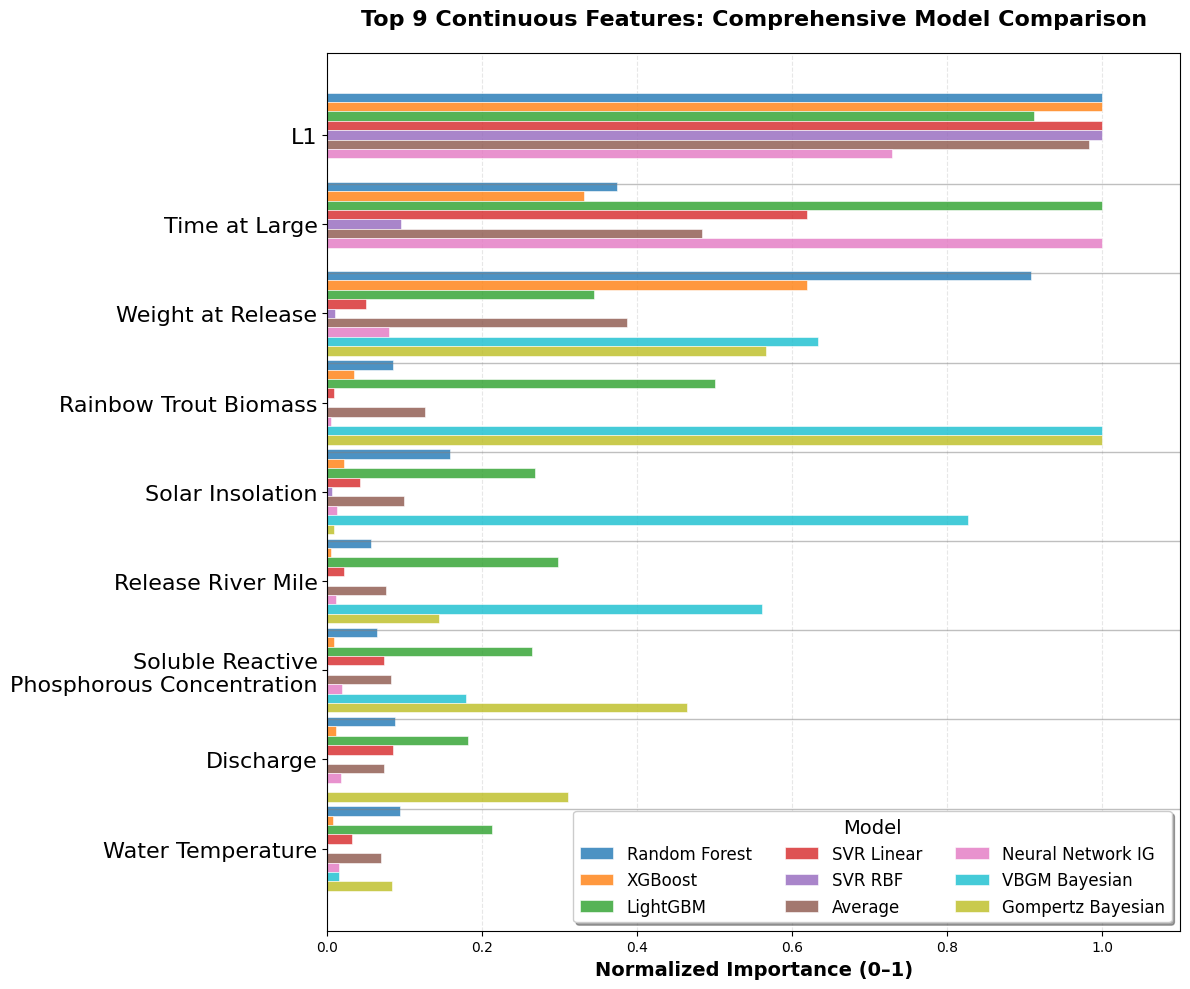


Continuous features results exported to: continuous_features_importance_comparison.csv
Analysis complete!

All continuous features with model importances and averages exported to: all_continuous_features_importance_with_average.csv
Top 10 features summary exported to: top_10_continuous_features_summary.csv

Summary Statistics:
Total continuous features analyzed: 9
Total models compared: 9

Top 5 features by average importance:
1. L1                                            Average: 0.7359
2. Time at Large                                 Average: 0.4337
3. Weight at Release                             Average: 0.3996
4. Rainbow Trout Biomass                         Average: 0.3066
5. Solar Insolation                              Average: 0.1605

Detailed Excel analysis exported to: feature_importance_detailed_analysis.xlsx
  - Sheet 'All Features': All continuous features with model importances and average
  - Sheet 'Top 10': Top 10 features only
  - Sheet 'Model Statistics': Summary

In [41]:
import matplotlib.pyplot as plt
import textwrap
import numpy as np
import pandas as pd

# Number of top features to display
top_n = 10

# Step 1: Check what we have in importances_matrix
print("Current columns in importances_matrix:")
for i, col in enumerate(importances_matrix.columns, 1):
    print(f"{i:2d}. {col}")

# Step 2: Ensure SVR RBF column exists (calculate if missing)
if 'SVR_Radial' not in importances_matrix.columns and 'SVR RBF' not in importances_matrix.columns:
    print("\nSVR_Radial column not found. Calculating from trained model...")
    
    # Get the trained SVR_Radial model
    svr_rbf_model = models["SVR_Radial"]
    
    # Calculate permutation importance for RBF SVR
    from sklearn.inspection import permutation_importance
    
    print("  Using permutation importance for RBF SVR...")
    perm_importance = permutation_importance(
        svr_rbf_model, 
        X_test_scaled, 
        y_test, 
        n_repeats=10,
        random_state=42,
        scoring='neg_mean_squared_error'
    )
    
    raw_importances = perm_importance.importances_mean
    
    # Normalize importances to [0, 1] scale
    imp_min, imp_max = raw_importances.min(), raw_importances.max()
    if imp_max != imp_min:
        norm_importances = (raw_importances - imp_min) / (imp_max - imp_min)
    else:
        norm_importances = np.zeros_like(raw_importances)
    
    # Add to importances matrix
    importances_matrix['SVR_Radial'] = norm_importances
    print(f"  SVR_Radial importance calculated and added")

# Step 3: Standardize column names for display
column_mapping = {}
for col in importances_matrix.columns:
    if col == 'SVR_Linear':
        column_mapping[col] = 'SVR Linear'
    elif col == 'SVR_Radial':
        column_mapping[col] = 'SVR RBF'
    elif 'SVR' in col and 'Linear' in col:
        column_mapping[col] = 'SVR Linear'
    elif 'SVR' in col and ('RBF' in col or 'Radial' in col):
        column_mapping[col] = 'SVR RBF'

# Rename columns
if column_mapping:
    importances_matrix = importances_matrix.rename(columns=column_mapping)
    print(f"\nRenamed columns: {column_mapping}")

# Step 4: Add other models if available
models_to_add = []

# Bayesian Linear Model
try:
    # Get Bayesian coefficients (excluding intercept)
    bayesian_coeffs = beta_mean[1:]  # Exclude intercept (first coefficient)
    
    # Normalize Bayesian coefficients to [0, 1] scale
    bayesian_abs = np.abs(bayesian_coeffs)
    bayesian_min, bayesian_max = bayesian_abs.min(), bayesian_abs.max()
    if bayesian_max != bayesian_min:
        bayesian_normalized = (bayesian_abs - bayesian_min) / (bayesian_max - bayesian_min)
    else:
        bayesian_normalized = np.zeros_like(bayesian_abs)
    
    importances_matrix['Bayesian Linear'] = bayesian_normalized
    models_to_add.append('Bayesian Linear')
    print(f"Added Bayesian Linear model")
except NameError:
    print("Bayesian model not available (beta_mean not found)")

# Neural Network IG
try:
    ig_scores = ig_results_df.set_index('Feature')['Abs_Mean_IG']
    ig_aligned = ig_scores.reindex(importances_matrix.index, fill_value=0)
    ig_min, ig_max = ig_aligned.min(), ig_aligned.max()
    if ig_max != ig_min:
        ig_normalized = (ig_aligned - ig_min) / (ig_max - ig_min)
    else:
        ig_normalized = pd.Series(np.zeros_like(ig_aligned), index=ig_aligned.index)
    
    importances_matrix['Neural Network IG'] = ig_normalized
    models_to_add.append('Neural Network IG')
    print(f"Added Neural Network IG model")
except NameError:
    print("Neural Network IG not available (ig_results_df not found)")

# VBGM Bayesian
try:
    # Try to find the VBGM idata object - it might have different names
    vbgm_idata = None
    vbgm_name = None
    
    # Check common variable names for VBGM results
    for var_name in ['idata_vbgm', 'idata', 'vbgm_idata', 'mcmc_idata']:
        if var_name in globals() and hasattr(globals()[var_name], 'posterior'):
            potential_idata = globals()[var_name]
            # Check if it has beta coefficients (either as 'beta' or individual beta[i] variables)
            data_vars = list(potential_idata.posterior.data_vars)
            if 'beta' in data_vars or any('beta[' in var for var in data_vars):
                # Additional check: make sure this isn't the Gompertz model
                if var_name != 'idata_gomp':
                    vbgm_idata = potential_idata
                    vbgm_name = var_name
                    break
    
    if vbgm_idata is not None:
        print(f"Found VBGM data in variable: {vbgm_name}")
        print(f"VBGM idata variables: {list(vbgm_idata.posterior.data_vars)}")
        
        # Handle different beta storage formats
        if 'beta' in vbgm_idata.posterior.data_vars:
            # Beta stored as a single array
            vbgm_beta_samples = vbgm_idata.posterior['beta'].values.reshape(-1, vbgm_idata.posterior['beta'].shape[-1])
        else:
            # Beta stored as individual beta[0], beta[1], etc.
            beta_vars = [var for var in vbgm_idata.posterior.data_vars if 'beta[' in var]
            beta_vars.sort(key=lambda x: int(x.split('[')[1].split(']')[0]))  # Sort by index
            
            beta_samples_list = []
            for beta_var in beta_vars:
                beta_samples_list.append(vbgm_idata.posterior[beta_var].values.flatten())
            
            vbgm_beta_samples = np.column_stack(beta_samples_list)
        
        vbgm_beta_mean = vbgm_beta_samples.mean(axis=0)
        vbgm_abs_importance = np.abs(vbgm_beta_mean)
        vbgm_min, vbgm_max = vbgm_abs_importance.min(), vbgm_abs_importance.max()
        if vbgm_max != vbgm_min:
            vbgm_normalized = (vbgm_abs_importance - vbgm_min) / (vbgm_max - vbgm_min)
        else:
            vbgm_normalized = np.zeros_like(vbgm_abs_importance)
        
        # Map to features using your predictor_columns
        if 'predictor_columns' in globals():
            # Create mapping from predictor columns to importances_matrix features
            vbgm_series = pd.Series(0.0, index=importances_matrix.index)
            
            for i, pred_col in enumerate(predictor_columns):
                if pred_col in importances_matrix.index and i < len(vbgm_normalized):
                    vbgm_series[pred_col] = vbgm_normalized[i]
            
            importances_matrix['VBGM Bayesian'] = vbgm_series
            models_to_add.append('VBGM Bayesian')
            print(f"Added VBGM Bayesian model with {len(vbgm_normalized)} coefficients")
            print(f"Mapped to {sum(vbgm_series > 0)} features in importances matrix")
        else:
            # Fallback to excluding biological variables
            vbgm_features = importances_matrix.index.difference(["L1", "Time at Large"])
            if len(vbgm_normalized) == len(vbgm_features):
                vbgm_series = pd.Series(0.0, index=importances_matrix.index)
                vbgm_series.loc[vbgm_features] = vbgm_normalized
                importances_matrix['VBGM Bayesian'] = vbgm_series
                models_to_add.append('VBGM Bayesian')
                print(f"Added VBGM Bayesian model with {len(vbgm_normalized)} coefficients (fallback mapping)")
            else:
                print(f"VBGM coefficient count mismatch: {len(vbgm_normalized)} coefficients vs {len(vbgm_features)} features")
    else:
        print("VBGM model not found - no beta variables in any idata objects")
        
except (NameError, KeyError, AttributeError) as e:
    print(f"VBGM model not available: {e}")

# Gompertz Bayesian
try:
    # Try to find the Gompertz idata object
    gompertz_idata = None
    gompertz_name = None
    
    # Check common variable names for Gompertz results
    for var_name in ['idata_gomp', 'idata_gompertz', 'gompertz_idata', 'mcmc_gomp']:
        if var_name in globals() and hasattr(globals()[var_name], 'posterior'):
            potential_idata = globals()[var_name]
            if 'beta' in potential_idata.posterior.data_vars:
                gompertz_idata = potential_idata
                gompertz_name = var_name
                break
    
    if gompertz_idata is not None:
        print(f"Found Gompertz data in variable: {gompertz_name}")
        print(f"Gompertz idata variables: {list(gompertz_idata.posterior.data_vars)}")
        
        gompertz_beta_samples = gompertz_idata.posterior['beta'].values.reshape(-1, gompertz_idata.posterior['beta'].shape[-1])
        gompertz_beta_mean = gompertz_beta_samples.mean(axis=0)
        gompertz_abs_importance = np.abs(gompertz_beta_mean)
        gompertz_min, gompertz_max = gompertz_abs_importance.min(), gompertz_abs_importance.max()
        if gompertz_max != gompertz_min:
            gompertz_normalized = (gompertz_abs_importance - gompertz_min) / (gompertz_max - gompertz_min)
        else:
            gompertz_normalized = np.zeros_like(gompertz_abs_importance)
        
        # Map to features (exclude biological variables)
        gompertz_features = importances_matrix.index.difference(["L1", "Time at Large"])
        if len(gompertz_normalized) == len(gompertz_features):
            gompertz_series = pd.Series(0.0, index=importances_matrix.index)
            gompertz_series.loc[gompertz_features] = gompertz_normalized
            importances_matrix['Gompertz Bayesian'] = gompertz_series
            models_to_add.append('Gompertz Bayesian')
            print(f"Added Gompertz Bayesian model with {len(gompertz_normalized)} coefficients")
        else:
            print(f"Gompertz coefficient count mismatch: {len(gompertz_normalized)} coefficients vs {len(gompertz_features)} features")
    else:
        print("Gompertz model not found - no 'beta' variable in any idata objects")
        
except (NameError, KeyError, AttributeError) as e:
    print(f"Gompertz model not available: {e}")

# Step 5: Filter to continuous features only (exclude dummy variables)
# Define continuous features (exclude all dummy variables)
continuous_features = [
    'L1',                                    # Initial length - biological baseline
    'Time at Large',                         # Growth period - temporal constraint  
    'Release River Mile',                    # Environmental predictors
    'Weight at Release', 
    'Discharge', 
    'Water Temperature', 
    'Solar Insolation',
    'Soluble Reactive Phosphorous Concentration', 
    'Rainbow Trout Biomass'
]

# Filter importances_matrix to only include continuous features that exist
available_continuous = [feat for feat in continuous_features if feat in importances_matrix.index]
importances_continuous = importances_matrix.loc[available_continuous]

print(f"\nContinuous features included in analysis ({len(available_continuous)} total):")
for i, feat in enumerate(available_continuous, 1):
    print(f"{i:2d}. {feat}")

# Step 6: Compute average importance and get top continuous features
avg_importance_continuous = importances_continuous.mean(axis=1)
top_continuous_features = avg_importance_continuous.sort_values(ascending=False).head(min(top_n, len(available_continuous))).index
subset_continuous = importances_continuous.loc[top_continuous_features]

print(f"\nTop {len(top_continuous_features)} Continuous Features by Average Importance:")
print("="*60)
for i, feature in enumerate(top_continuous_features, 1):
    avg_imp = avg_importance_continuous[feature]
    print(f"{i:2d}. {feature}: {avg_imp:.3f}")

# Step 7: Create visualization for continuous features only
print(f"\nFinal models included ({len(subset_continuous.columns)} total):")
for i, col in enumerate(subset_continuous.columns, 1):
    print(f"{i:2d}. {col}")

fig, ax = plt.subplots(figsize=(12, 10))  # Adjusted height for fewer features
bar_height = 0.10  # Bar thickness
spacing = 0.05  # Add spacing between feature groups
index = np.arange(len(top_continuous_features)) * (len(subset_continuous.columns) * bar_height + spacing)
model_names = subset_continuous.columns.tolist()

# Color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#17becf', '#bcbd22']
if len(model_names) > len(colors):
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))

# Plot bars
for i, model_name in enumerate(model_names):
    ax.barh(index + i * bar_height,
            subset_continuous[model_name].values,
            bar_height,
            label=model_name,
            color=colors[i % len(colors)],
            alpha=0.8,
            edgecolor='white',
            linewidth=0.5)

# Add horizontal lines between each feature group
for i in range(len(top_continuous_features) - 1):
    # Calculate position between feature groups
    line_y = index[i] + len(model_names) * bar_height + spacing/2
    ax.axhline(y=line_y, color='gray', linestyle='-', alpha=0.5, linewidth=1)

# Formatting with larger y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, 25)) for label in top_continuous_features]
center_positions = index + bar_height * (len(model_names) - 1) / 2
ax.set_yticks(center_positions)
ax.set_yticklabels(wrapped_labels, fontsize=16)

ax.set_xlabel("Normalized Importance (0–1)", fontsize=14, fontweight='bold')
ax.set_title(f"Top {len(top_continuous_features)} Continuous Features: Comprehensive Model Comparison", 
             fontsize=16, fontweight='bold', pad=20)
ax.invert_yaxis()

# Legend with smaller font to avoid overlap with bars
ncols = min(3, len(model_names))
ax.legend(title="Model", fontsize=12, title_fontsize=14,  # Reduced from 14 and 16 to 12 and 14
          loc='lower right', frameon=True, fancybox=True, shadow=True,
          ncol=ncols)

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.set_xlim(0, 1.1)

plt.tight_layout()
plt.savefig("coefficients.png", dpi=300, bbox_inches='tight')
plt.show()

# Step 8: Export continuous features results
subset_continuous.to_csv('continuous_features_importance_comparison.csv')
print(f"\nContinuous features results exported to: continuous_features_importance_comparison.csv")
print("Analysis complete!")

# Step 9: Save all importances with averages
# Create a comprehensive export with all continuous features and their importances

# Calculate average importance across all models
avg_importance_all = importances_continuous.mean(axis=1)

# Create a comprehensive dataframe with all models plus average
importances_with_average = importances_continuous.copy()
importances_with_average['Average'] = avg_importance_all

# Sort by average importance (descending)
importances_with_average = importances_with_average.sort_values('Average', ascending=False)

# Export full results
output_filename = 'all_continuous_features_importance_with_average.csv'
importances_with_average.to_csv(output_filename)
print(f"\nAll continuous features with model importances and averages exported to: {output_filename}")

# Also create a summary table showing just the top N features
top_n_summary = importances_with_average.head(top_n)
summary_filename = f'top_{top_n}_continuous_features_summary.csv'
top_n_summary.to_csv(summary_filename)
print(f"Top {top_n} features summary exported to: {summary_filename}")

# Print summary statistics
print(f"\nSummary Statistics:")
print("="*80)
print(f"Total continuous features analyzed: {len(importances_with_average)}")
print(f"Total models compared: {len(importances_continuous.columns)}")
print(f"\nTop 5 features by average importance:")
for i, (feature, row) in enumerate(importances_with_average.head(5).iterrows(), 1):
    print(f"{i}. {feature:45s} Average: {row['Average']:.4f}")

# Optional: Create a detailed Excel file with multiple sheets
try:
    with pd.ExcelWriter('feature_importance_detailed_analysis.xlsx', engine='openpyxl') as writer:
        # Sheet 1: All features with average
        importances_with_average.to_excel(writer, sheet_name='All Features')
        
        # Sheet 2: Top N features only
        top_n_summary.to_excel(writer, sheet_name=f'Top {top_n}')
        
        # Sheet 3: Model-by-model statistics
        model_stats = pd.DataFrame({
            'Model': importances_continuous.columns,
            'Mean Importance': importances_continuous.mean(axis=0),
            'Std Importance': importances_continuous.std(axis=0),
            'Max Importance': importances_continuous.max(axis=0),
            'Min Importance': importances_continuous.min(axis=0)
        })
        model_stats.to_excel(writer, sheet_name='Model Statistics', index=False)
        
        # Sheet 4: Feature-by-feature statistics
        feature_stats = pd.DataFrame({
            'Feature': importances_continuous.index,
            'Mean Importance': importances_continuous.mean(axis=1),
            'Std Importance': importances_continuous.std(axis=1),
            'Max Importance': importances_continuous.max(axis=1),
            'Min Importance': importances_continuous.min(axis=1),
            'Max Model': importances_continuous.idxmax(axis=1),
            'Min Model': importances_continuous.idxmin(axis=1)
        })
        feature_stats = feature_stats.sort_values('Mean Importance', ascending=False)
        feature_stats.to_excel(writer, sheet_name='Feature Statistics', index=False)
        
    print(f"\nDetailed Excel analysis exported to: feature_importance_detailed_analysis.xlsx")
    print("  - Sheet 'All Features': All continuous features with model importances and average")
    print(f"  - Sheet 'Top {top_n}': Top {top_n} features only")
    print("  - Sheet 'Model Statistics': Summary statistics by model")
    print("  - Sheet 'Feature Statistics': Summary statistics by feature")
    
except ImportError:
    print("\nNote: openpyxl not available. Excel export skipped. Install with: pip install openpyxl")

print("\nAll exports complete!")

# Hypothesis Test

In [ ]:
# Clean up the model indexing before Bayesian analysis
import pandas as pd
import numpy as np

print("=== CLEANING MODEL INDICES ===")
print("Original data:")
print(highlight_df[['Model', 'model_idx', 'RMSE']])

# Reset model indices to be sequential (0, 1, 2, ..., n-1)
highlight_df_clean = highlight_df.copy()
highlight_df_clean['model_idx_original'] = highlight_df_clean['model_idx']  # Keep original for reference
highlight_df_clean['model_idx'] = range(len(highlight_df_clean))  # Sequential 0,1,2,3...

print(f"\nCleaned data:")
print(highlight_df_clean[['Model', 'model_idx_original', 'model_idx', 'RMSE']])

# Update the arrays for the Bayesian model
model_names = highlight_df_clean['Model'].values
rmse_obs = np.array(highlight_df_clean['RMSE'].values)
model_idx = np.array(highlight_df_clean['model_idx'].values)
n_models = len(model_names)

print(f"\nArrays for Bayesian analysis:")
print(f"model_names: {model_names}")
print(f"model_idx: {model_idx}")
print(f"rmse_obs: {rmse_obs}")
print(f"n_models: {n_models}")

# Verify the mapping
print(f"\nModel mapping verification:")
for i in range(len(model_names)):
    print(f"Index {i}: {model_names[i]} -> RMSE {rmse_obs[i]}")

# Now run the Bayesian model with clean indices
from numpyro import sample, plate
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
import arviz as az
import jax.numpy as jnp
from jax import random

# Data-informed scaling
rmse_mean = float(rmse_obs.mean())
rmse_std = float(rmse_obs.std())

print(f"\nData stats: Mean RMSE = {rmse_mean:.2f}, Std RMSE = {rmse_std:.2f}")
print(f"RMSE range: {rmse_obs.min():.2f} to {rmse_obs.max():.2f}")

# Simple model with shared sigma
def rmse_model_simple(model_idx, rmse_obs=None):
    # Individual means for each model - no hierarchy
    mu = sample("mu", dist.Normal(rmse_mean, 50.0).expand([n_models]))
    
    # Single shared sigma (much more stable)
    sigma = sample("sigma", dist.HalfNormal(20.0))
    
    with plate("data", len(rmse_obs)):
        sample("obs", dist.Normal(mu[model_idx], sigma), obs=rmse_obs)

# Run the Bayesian analysis with clean indices
print("\n=== RUNNING BAYESIAN ANALYSIS ===")
rng_key = random.PRNGKey(42)

kernel_simple = NUTS(
    rmse_model_simple,
    target_accept_prob=0.80,
    max_tree_depth=10
)

mcmc_simple = MCMC(kernel_simple, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc_simple.run(rng_key, model_idx=model_idx, rmse_obs=rmse_obs)
idata_clean = az.from_numpyro(mcmc_simple)

divergences = idata_clean.sample_stats['diverging'].sum().item()
print(f"Divergences: {divergences}")

if divergences < 50:
    print("✅ Model converged successfully with clean indices!")
    
    # Now run the stochastic dominance analysis
    print("\n=== STOCHASTIC DOMINANCE ANALYSIS ===")
    
    # Stack the posterior samples
    mu_samples = idata_clean.posterior["mu"].stack(sample=("chain", "draw")).values
    
    print(f"Posterior samples shape: {mu_samples.shape}")
    print(f"Number of models: {len(model_names)}")
    
    # Verify posterior means align with observed RMSE
    print(f"\nPosterior vs Observed RMSE:")
    for i, model in enumerate(model_names):
        obs_rmse = rmse_obs[i]
        post_mean = mu_samples[i].mean()
        post_std = mu_samples[i].std()
        print(f"{model}: Observed={obs_rmse:.2f}, Posterior={post_mean:.2f}±{post_std:.2f}")
    
    # Calculate pairwise probabilities
    import itertools
    
    pairwise_probs = pd.DataFrame(index=model_names, columns=model_names, dtype=object)
    
    for i, j in itertools.product(range(len(model_names)), repeat=2):
        if i == j:
            pairwise_probs.iloc[i, j] = "-"
        else:
            # P(model i has lower RMSE than model j)
            prob = (mu_samples[i] < mu_samples[j]).mean()
            pairwise_probs.iloc[i, j] = f"{prob:.3f}"
    
    print(f"\nPAIRWISE STOCHASTIC DOMINANCE PROBABILITIES")
    print("P(row model < column model) - probability row has lower RMSE")
    print(pairwise_probs)
    
    # Calculate dominance counts
    dominance_counts = []
    for i, model in enumerate(model_names):
        beats_count = 0
        beaten_models = []
        
        for j, other_model in enumerate(model_names):
            if i != j:
                prob = (mu_samples[i] < mu_samples[j]).mean()
                if prob > 0.5:
                    beats_count += 1
                    beaten_models.append(other_model)
        
        dominance_counts.append({
            'Model': model,
            'Beats_Count': beats_count,
            'Beaten_Models': beaten_models
        })
    
    # Sort by dominance count
    dominance_df = pd.DataFrame(dominance_counts).sort_values('Beats_Count', ascending=False)
    
    print(f"\nMODEL RANKING BY STOCHASTIC DOMINANCE")
    for idx, row in dominance_df.iterrows():
        print(f"{row['Beats_Count']:2d} models beaten: {row['Model']}")
        if row['Beaten_Models']:
            beaten_str = ', '.join(row['Beaten_Models'])
            print(f"    Beats: {beaten_str}")
        print()

else:
    print(f"⚠️ Still {divergences} divergences. Need to debug further.")

# Store the clean data for future use
highlight_df = highlight_df_clean

## Reporting

In [ ]:
import arviz as az
import numpy as np
import pandas as pd
import itertools

# Use the final converged model (idata_improved from the previous code)
# Check which variables are available
print("Available posterior variables:", list(idata_improved.posterior.data_vars.keys()))

# Stack the 'chain' and 'draw' dimensions into one dimension called 'sample'
mu_samples = idata_improved.posterior["mu"].stack(sample=("chain", "draw")).values  # shape: (n_models, n_samples)

print(f"Posterior samples shape: {mu_samples.shape}")
print(f"Number of models: {len(model_names)}")
print(f"Number of posterior samples: {mu_samples.shape[1]}")

# Get model names (use the original order from model creation)
print(f"Model names: {model_names}")

# Initialize the pairwise probability matrix
pairwise_probs = pd.DataFrame(index=model_names, columns=model_names, dtype=object)

# Compute P(mu[i] < mu[j]) for all pairs (lower RMSE is better)
print("\nComputing pairwise dominance probabilities...")
for i, j in itertools.product(range(len(model_names)), repeat=2):
    if i == j:
        pairwise_probs.iloc[i, j] = "-"
    else:
        # P(model i has lower RMSE than model j)
        prob = (mu_samples[i] < mu_samples[j]).mean()
        pairwise_probs.iloc[i, j] = f"{prob:.3f}"

# Display the DataFrame
print("\n" + "="*80)
print("PAIRWISE STOCHASTIC DOMINANCE PROBABILITIES")
print("P(row model < column model) - probability row has lower RMSE")
print("="*80)
print(pairwise_probs)

# Calculate dominance counts (how many models each one beats with P > 0.5)
dominance_counts = []
for i, model in enumerate(model_names):
    beats_count = 0
    beaten_models = []
    
    for j, other_model in enumerate(model_names):
        if i != j:
            prob = (mu_samples[i] < mu_samples[j]).mean()
            if prob > 0.5:
                beats_count += 1
                beaten_models.append(other_model)
    
    dominance_counts.append({
        'Model': model,
        'Beats_Count': beats_count,
        'Beaten_Models': beaten_models
    })

# Sort by dominance count
dominance_df = pd.DataFrame(dominance_counts).sort_values('Beats_Count', ascending=False)

print("\n" + "="*80)
print("MODEL RANKING BY STOCHASTIC DOMINANCE")
print("="*80)
for idx, row in dominance_df.iterrows():
    print(f"{row['Beats_Count']:2d} models beaten: {row['Model']}")
    if row['Beaten_Models']:
        beaten_str = ', '.join(row['Beaten_Models'])
        print(f"    Beats: {beaten_str}")
    print()

# Create numerical matrix for further analysis
numerical_probs = pd.DataFrame(index=model_names, columns=model_names, dtype=float)
for i, j in itertools.product(range(len(model_names)), repeat=2):
    if i == j:
        numerical_probs.iloc[i, j] = np.nan
    else:
        numerical_probs.iloc[i, j] = (mu_samples[i] < mu_samples[j]).mean()

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

# Posterior means and credible intervals for each model
posterior_summary = []
for i, model in enumerate(model_names):
    samples = mu_samples[i]
    posterior_summary.append({
        'Model': model,
        'Mean_RMSE': samples.mean(),
        'Std_RMSE': samples.std(),
        'CI_2.5%': np.percentile(samples, 2.5),
        'CI_97.5%': np.percentile(samples, 97.5),
        'Dominance_Count': dominance_df[dominance_df['Model'] == model]['Beats_Count'].iloc[0]
    })

summary_df = pd.DataFrame(posterior_summary).sort_values('Mean_RMSE')
print("\nPosterior Summary (sorted by mean RMSE):")
print(summary_df.round(3))

# Check for convergence issues in the final results
print(f"\nDivergences in final model: {idata_improved.sample_stats['diverging'].sum().item()}")
if idata_improved.sample_stats['diverging'].sum().item() > 50:
    print("⚠️  WARNING: High number of divergences - results may be unreliable!")
    print("Consider using the simpler models or alternative approaches.")
else:
    print("✅ Model converged reasonably well!")

# Export results for LaTeX table
print(f"\n" + "="*60)
print("EXPORTING RESULTS")
print("="*60)

# Save numerical probabilities to CSV for easy LaTeX conversion
numerical_probs.to_csv('stochastic_dominance_probabilities.csv')
dominance_df.to_csv('model_dominance_ranking.csv', index=False)
summary_df.to_csv('posterior_summary.csv', index=False)

print("Exported files:")
print("- stochastic_dominance_probabilities.csv")
print("- model_dominance_ranking.csv") 
print("- posterior_summary.csv")

print(f"\nUse 'numerical_probs' DataFrame for further analysis:")
print(f"Shape: {numerical_probs.shape}")
print("Access with: numerical_probs.loc['Model1', 'Model2'] for P(Model1 < Model2)")

In [ ]:
print("RMSE values in highlight_df:")
for i, row in highlight_df.iterrows():
    print(f"{row['Model']}: {row['RMSE']}")

In [ ]:
print("Model index mapping:")
for i, model in enumerate(model_names):
    print(f"{i}: {model}")
print("\nFirst few rows of data:")
print(highlight_df[['Model', 'model_idx', 'RMSE']].head(10))

# Hyperparameter Runs (Converted to Markdown)

## Hyperparameter Tuning, Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=1  # Let GridSearch handle parallelization
)

# Focused parameter distribution
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [15, 25, None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']  # Added this for better performance
}

# Fast randomized search
fast_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=25,  # Try 25 combinations instead of hundreds
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

fast_search.fit(X_train, y_train)
best_rf_model = fast_search.best_estimator_
print("Best Parameters:\n", fast_search.best_params_)
print("Best Score:", fast_search.best_score_)

## Hyperparameter Tuning, XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Faster XGBoost setup
xgb_model = xgb.XGBRegressor(
    random_state=42,
    verbosity=0,
    tree_method='hist',  # Faster algorithm
    n_jobs=1  # Let GridSearch handle parallelization
)

# Focused parameter distribution with higher learning rates
param_distributions = {
    'eta': [0.05, 0.1, 0.15, 0.2],  # Higher learning rates
    'max_depth': [3, 4, 5],
    'n_estimators': [200, 400, 600, 800],  # Fewer trees due to higher eta
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1],  # L1 regularization
    'reg_lambda': [1, 1.5]  # L2 regularization
}

# Fast randomized search
fast_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=25,  # Try 25 combinations
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

fast_search.fit(X_train, y_train)
best_xgb_model = fast_search.best_estimator_
print("Best Parameters:\n", fast_search.best_params_)

## Hyperparameter Tuning, LGBM

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Optimized LightGBM setup
lgbm = LGBMRegressor(
    random_state=42,
    verbose=-1,
    boosting_type='gbdt',
    objective='regression'
)

# Focused parameter distribution
param_distributions = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [15, 20, -1],
    'num_leaves': [31, 50, 100],  # Important for LightGBM
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1]  # L2 regularization
}

# Fast randomized search
fast_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=20,  # Try 20 combinations
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

fast_search.fit(X_train, y_train)
best_lgbm_model = fast_search.best_estimator_
print("Best Parameters:\n", fast_search.best_params_)

## Hyperparameter Tuning, SVR

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

svr=SVR()
# Use randomized search with reduced parameters
param_distributions = {
    'kernel': ['linear', 'poly','rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 0.01, 0.1]  # Only used for rbf
}

# Fast randomized search
fast_search = RandomizedSearchCV(
    svr,
    param_distributions,
    n_iter=15,  # Much faster than full grid
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

fast_search.fit(X_train_scaled, y_train)
best_svr_model = fast_search.best_estimator_
print(f"Best SVR Parameters: {fast_search.best_params_}")